# Passo 1: Análise da consistência dos dados

## Importação das bibliotecas

In [115]:
#Bibliotecas de manipulação de dados
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import spacy
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer 
from unidecode import unidecode 
from wordcloud import WordCloud
from PIL import Image
#from spellchecker import SpellChecker (tentei usar essa lib mas não foi efetiva)

# Bibliotecas para preprocessamento e métricas de avaliação de modelos
from sklearn.model_selection import train_test_split,KFold,cross_validate,cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,roc_auc_score,classification_report
from mlxtend.plotting import plot_confusion_matrix
from mlxtend.evaluate import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Word2Vec,doc2vec


# Bibliotecas com os modelos de classificação
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Configurações para padronização dos gráficos
# Para ver todos os parâmetros usar o comando plt.rcParams.keys()
sns.set(rc={
                    'axes.labelsize': 12.0,
                    'axes.titlecolor': 'black',
                    'axes.titleweight': 'bold',
                    'axes.labelweight': 'bold',
                    'axes.titlesize': 20.0,
                    'figure.figsize': [15,10],
                    'figure.titlesize': 'xx-large',
                    'figure.titleweight': 'bold',
                    })

## Análise de missings, duplicados e dados com comportamento anómalo

In [2]:
words_dirty_train = pd.read_csv('Train3Classes.csv')
words_dirty_sub = pd.read_csv('Subm3Classes.csv')

display(words_dirty_train,words_dirty_sub)

id                                         tweet_text  \
0      1049721159292346368  Rio elege maior bancada policial de sua histór...   
1      1046251157025423360  fiquei tão triste quando eu vi o preço da câme...   
2      1041744620206653440  Para Theresa May, seu plano para o Brexit é a ...   
3      1046937084727107589  caralho eu quero proteger a danielly em um pot...   
4      1047326854229778432                         @SiCaetano_ viva o caos :)   
...                    ...                                                ...   
94995  1041831666883321856  Cuba e defensor de direitos humanos se unem co...   
94996  1032352892194369536  #Oportunidade ➡️ Venha fazer parte da nossa eq...   
94997  1046785538542440448  @96syoo EU SEI 😭😭 é por isso que significa mui...   
94998  1045457469110177792            @louistsexhes N te conheço mas posta :D   
94999  1046239135286136832                meu deus :( https://t.co/BlXazxZeKq   

                           tweet_date  sentiment     query_used  
0      Tue Oct 09 18:00:01 +0000 2018          2          folha  
1      Sun Sep 30 04:11:28 +0000 2018          0             :(  
2      Mon Sep 17 17:44:06 +0000 2018          2          exame  
3      Tue Oct 02 01:37:06 +0000 2018          0             :(  
4      Wed Oct 03 03:25:55 +0000 2018          1             :)  
...                               ...        ...            ...  
94995  Mon Sep 17 23:30:00 +0000 2018          2   jornaloglobo  
94996  Wed Aug 22 19:44:44 +0000 2018          2  #oportunidade  
94997  Mon Oct 01 15:34:55 +0000 2018          0             :(  
94998  Thu Sep 27 23:37:38 +0000 2018          1             :)  
94999  Sun Sep 30 03:23:42 +0000 2018          0             :(  

[95000 rows x 5 columns]

id                                         tweet_text  \
0     1046764676707753987  Apartamento Vila Mariana Praça Monteiro dos Sa...   
1     1047329264943751169  @FalleNCS @BrasilGameShow quero 1x1 de scout. ...   
2     1045443874947313665  mais uma analógica no correio à minha espera :...   
3     1040484298711814144  Em festa de posse como presidente do STF, Toff...   
4     1045411876887306240  @thethiagor @jubsilva @GSCISA @GrupoMulheRIs A...   
...                   ...                                                ...   
4995  1049243861732794369  Não é nada demais , apenas a verdade :) — Oh.....   
4996  1039334757690163201  Veja o que é #FATO ou #FAKE na entrevista de A...   
4997  1049286902577356801  @nattvieiira de quem???? queria ver, eu sai po...   
4998  1045349300744671232  ASSASSIN'S CREED ORIGINS: ENFRENTANDO OS IRMÃO...   
4999  1046943420210659328  a gnt conversava muito mas paramos :( te acho ...   

                          tweet_date query_used  
0     Mon Oct 01 14:12:01 +0000 2018         :)  
1     Wed Oct 03 03:35:29 +0000 2018         :)  
2     Thu Sep 27 22:43:37 +0000 2018         :)  
3     Fri Sep 14 06:16:02 +0000 2018      folha  
4     Thu Sep 27 20:36:28 +0000 2018         :)  
...                              ...        ...  
4995  Mon Oct 08 10:23:25 +0000 2018         :)  
4996  Tue Sep 11 02:08:10 +0000 2018      #fato  
4997  Mon Oct 08 13:14:27 +0000 2018         :(  
4998  Thu Sep 27 16:27:49 +0000 2018         :)  
4999  Tue Oct 02 02:02:17 +0000 2018         :(  

[5000 rows x 4 columns]

Na base de treino temos 95 mil linhas com uma coluna de id, uma coluna contento os tweets, uma coluna contento a data, uma coluna contento o sentimento e uma coluna contento a query usada.

Na base de submissão (ou produção) temos somente 5 mil linhas com a mesma coluna, porém sem a coluna de sentimento, a qual iremos prever o resultado após nosso modelo final de NLP

In [3]:
words_dirty_train.info(),words_dirty_sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95000 entries, 0 to 94999
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          95000 non-null  int64 
 1   tweet_text  95000 non-null  object
 2   tweet_date  95000 non-null  object
 3   sentiment   95000 non-null  int64 
 4   query_used  95000 non-null  object
dtypes: int64(2), object(3)
memory usage: 3.6+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          5000 non-null   int64 
 1   tweet_text  5000 non-null   object
 2   tweet_date  5000 non-null   object
 3   query_used  5000 non-null   object
dtypes: int64(1), object(3)
memory usage: 156.4+ KB


(None, None)

Os datasets não tem dados missing. Vamos analisar se existem dados duplicados

In [4]:
#Criando um filtro para pegar os dados duplicados
filter = words_dirty_train.duplicated()
filter_sub = words_dirty_sub.duplicated()
#Visualizando os valores duplicados em cada dataset
display(words_dirty_train[filter],words_dirty_sub[filter_sub])

Empty DataFrame
Columns: [id, tweet_text, tweet_date, sentiment, query_used]
Index: []

Empty DataFrame
Columns: [id, tweet_text, tweet_date, query_used]
Index: []

Também não existem dados duplicados, o que é ótimo

In [5]:
#Analisando se algum valor da base de treino está na base de submissão
id_sub_in_train = [client_id for client_id in words_dirty_train['id'] if client_id in words_dirty_sub['id']]

words_dirty_train.loc[id_sub_in_train,:]

Empty DataFrame
Columns: [id, tweet_text, tweet_date, sentiment, query_used]
Index: []

Nenhum id de treino existe na base de produção. Vamos analisar se existem id que fazem mais de um tweet ou se são somente ids únicos

In [6]:
print("Na base de treino existem 95 mil linhas e o volume de id únicos de: ",words_dirty_train['id'].nunique())
print("Na base de submissão existem 5 mil linhas e o volume de id únicos de: ",words_dirty_sub['id'].nunique())


Na base de treino existem 95 mil linhas e o volume de id únicos de:  94987
Na base de submissão existem 5 mil linhas e o volume de id únicos de:  5000


Existem 13 clientes que fizeram mais de um tweet na base de treino e nenhum na base de validação. Dessa forma essa coluna não parece ser importante e posteriomente poderá ser descartada

Antes de iniciarmos a análise exploratória, vamos fazer uma limpeza mínima dos dados para facilitar a manipulação e criar algumas colunas úteis

In [7]:
def min_clean_data(data_train, data_sub):
    #Dropando a coluna ID
    words_dirty_train_clean = data_train.drop(columns=['id'])
    words_dirty_sub_clean = data_sub.drop(columns=['id'])

    #Mudando o nome das colunas para facilitar a manipulação
    words_dirty_train_clean.columns = ['text','data','sentiment','query']
    words_dirty_sub_clean.columns = ['text','data','query']

    #Criando uma coluna no formato datetime
    words_dirty_train_clean['date'] = pd.to_datetime(words_dirty_train_clean['data'])
    words_dirty_sub_clean['date'] = pd.to_datetime(words_dirty_sub_clean['data'])

    #Criando uma coluna de mês
    words_dirty_train_clean['month'] = words_dirty_train_clean['date'].dt.month
    words_dirty_sub_clean['month'] = words_dirty_sub_clean['date'].dt.month

    #Criando uma coluna de dia
    words_dirty_train_clean['day'] = words_dirty_train_clean['date'].dt.day
    words_dirty_sub_clean['day'] = words_dirty_sub_clean['date'].dt.day

    #Criando uma coluna de hora
    words_dirty_train_clean['hour'] = words_dirty_train_clean['date'].dt.hour
    words_dirty_sub_clean['hour'] = words_dirty_sub_clean['date'].dt.hour

    #Dropando a coluna original de data e deixando a coluna de data sem horas
    words_dirty_train_clean = words_dirty_train_clean.drop(columns=['data'])
    words_dirty_sub_clean = words_dirty_sub_clean.drop(columns=['data'])
    words_dirty_train_clean['date'] = words_dirty_train_clean['date'].dt.date
    words_dirty_sub_clean['date'] =  words_dirty_sub_clean['date'].dt.date

    return words_dirty_train_clean, words_dirty_sub_clean

In [8]:
words_dirty_train_clean, words_dirty_sub_clean = min_clean_data(words_dirty_train, words_dirty_sub)

display(words_dirty_train_clean,words_dirty_sub_clean)

text  sentiment  \
0      Rio elege maior bancada policial de sua histór...          2   
1      fiquei tão triste quando eu vi o preço da câme...          0   
2      Para Theresa May, seu plano para o Brexit é a ...          2   
3      caralho eu quero proteger a danielly em um pot...          0   
4                             @SiCaetano_ viva o caos :)          1   
...                                                  ...        ...   
94995  Cuba e defensor de direitos humanos se unem co...          2   
94996  #Oportunidade ➡️ Venha fazer parte da nossa eq...          2   
94997  @96syoo EU SEI 😭😭 é por isso que significa mui...          0   
94998            @louistsexhes N te conheço mas posta :D          1   
94999                meu deus :( https://t.co/BlXazxZeKq          0   

               query        date  month  day  hour  
0              folha  2018-10-09     10    9    18  
1                 :(  2018-09-30      9   30     4  
2              exame  2018-09-17      9   17    17  
3                 :(  2018-10-02     10    2     1  
4                 :)  2018-10-03     10    3     3  
...              ...         ...    ...  ...   ...  
94995   jornaloglobo  2018-09-17      9   17    23  
94996  #oportunidade  2018-08-22      8   22    19  
94997             :(  2018-10-01     10    1    15  
94998             :)  2018-09-27      9   27    23  
94999             :(  2018-09-30      9   30     3  

[95000 rows x 7 columns]

text  query        date  \
0     Apartamento Vila Mariana Praça Monteiro dos Sa...     :)  2018-10-01   
1     @FalleNCS @BrasilGameShow quero 1x1 de scout. ...     :)  2018-10-03   
2     mais uma analógica no correio à minha espera :...     :)  2018-09-27   
3     Em festa de posse como presidente do STF, Toff...  folha  2018-09-14   
4     @thethiagor @jubsilva @GSCISA @GrupoMulheRIs A...     :)  2018-09-27   
...                                                 ...    ...         ...   
4995  Não é nada demais , apenas a verdade :) — Oh.....     :)  2018-10-08   
4996  Veja o que é #FATO ou #FAKE na entrevista de A...  #fato  2018-09-11   
4997  @nattvieiira de quem???? queria ver, eu sai po...     :(  2018-10-08   
4998  ASSASSIN'S CREED ORIGINS: ENFRENTANDO OS IRMÃO...     :)  2018-09-27   
4999  a gnt conversava muito mas paramos :( te acho ...     :(  2018-10-02   

      month  day  hour  
0        10    1    14  
1        10    3     3  
2         9   27    22  
3         9   14     6  
4         9   27    20  
...     ...  ...   ...  
4995     10    8    10  
4996      9   11     2  
4997     10    8    13  
4998      9   27    16  
4999     10    2     2  

[5000 rows x 6 columns]

# Passo 2: Análise exploratória e Pre Processamento

## Analise exploratória antes do pré processamento

Primeiro vamos olhar para a coluna de datas

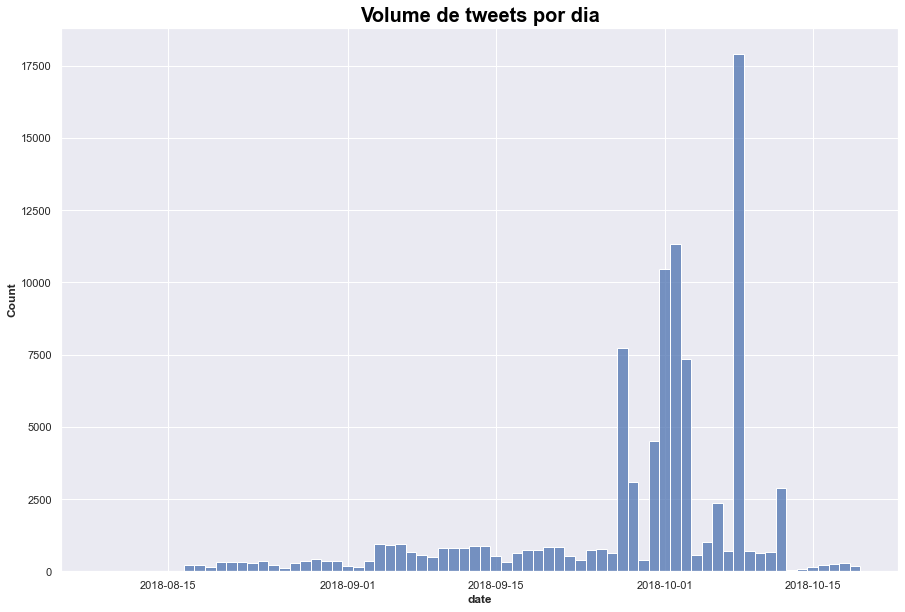

In [9]:
#Criando um histograma de volume de tweets por dia
graph = sns.histplot(data=words_dirty_train_clean['date'])
graph.set_title('Volume de tweets por dia');

Entre o dia 20 de setembro e o dia 10 de outubro parece ser havido um grande volume de tweets. Depois veremos o conteúdo dos tweets nesse intervalo de data para enteder o que ocorreu nesse período

Text(0.5, 0, 'Hora do dia')

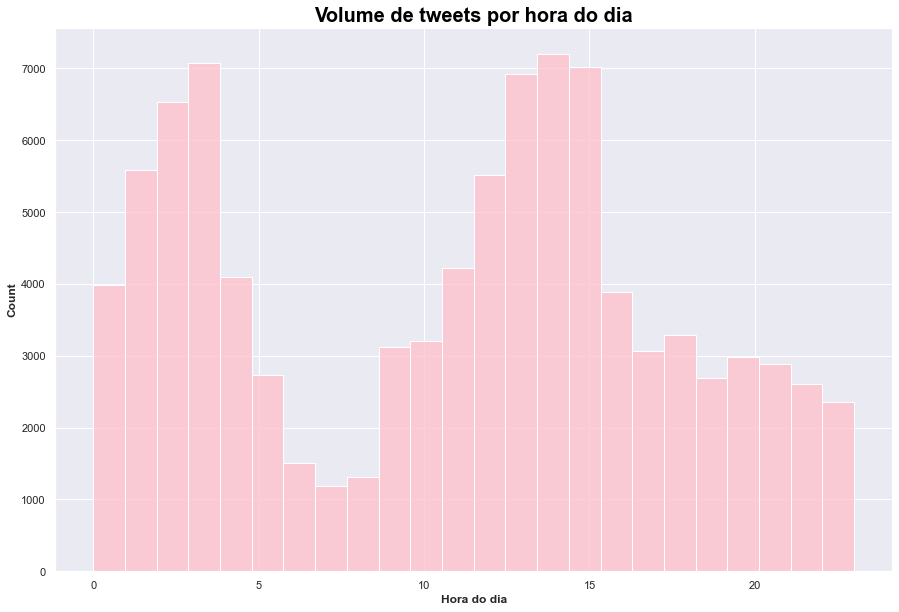

In [10]:
#Criando um histograma de volume de tweets por hora
graph = sns.histplot(data=words_dirty_train_clean['hour'],bins=24,color='pink')
graph.set_title('Volume de tweets por hora do dia')
graph.set_xlabel('Hora do dia')

O volume de tweets foi bem intenso entre 2h e 4h da madrugada e entre 11h e 15 h. Vamos olhar mês a mês para entender melhor esse comportamento

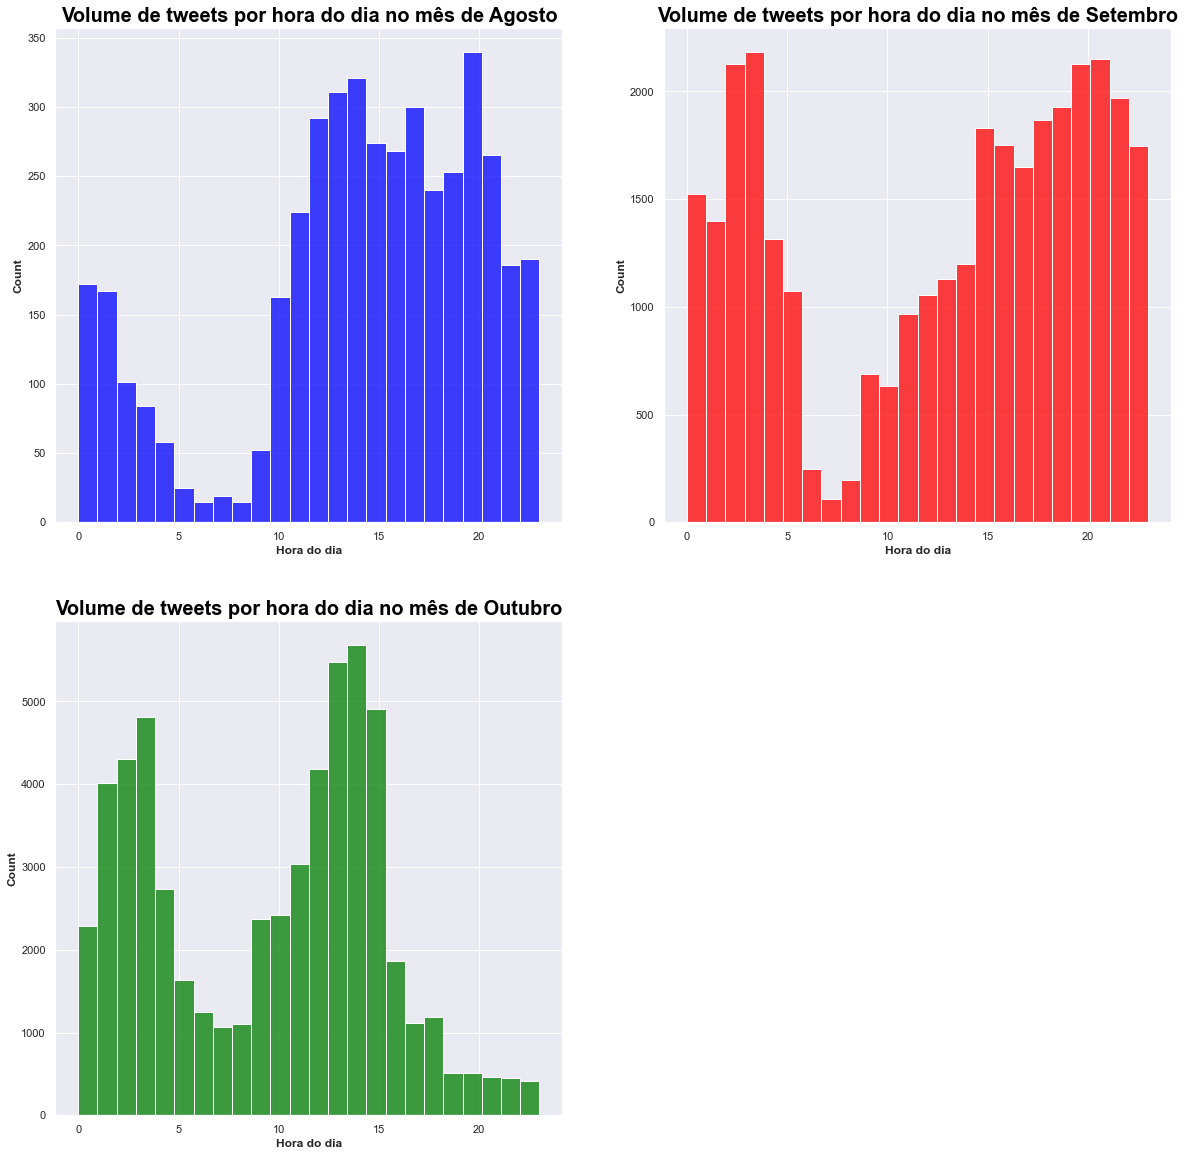

In [11]:
#Criando um grid de subplots
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(20,20))
axes = axes.ravel()
color = ['blue','red','green']

#Criando um histograma para cada mês do ano
for i, ax,c in zip([8,9,10],axes,color):
    filter = words_dirty_train_clean['month'] == i
    graph = sns.histplot(data=words_dirty_train_clean[filter],x='hour',bins=24,ax=ax,color=c)
    if i == 8: 
        i = "Agosto" 
    elif i == 9:  
        i = "Setembro" 
    else: 
        i = "Outubro"
    graph.set_title('Volume de tweets por hora do dia no mês de '+str(i))
    graph.set_xlabel('Hora do dia')

fig.delaxes(axes[3])

Em agosto o volume de tweets foi bem irrisório, comparativamente a outubro e setembro.

Em setembro o volume de tweets entre 15h e 23h foi bem elevado. Já em outubro o padrão foi o mesmo de quando consideramos todos os meses tendo altos volumes entre 2h - 4h e 11h - 15h. 

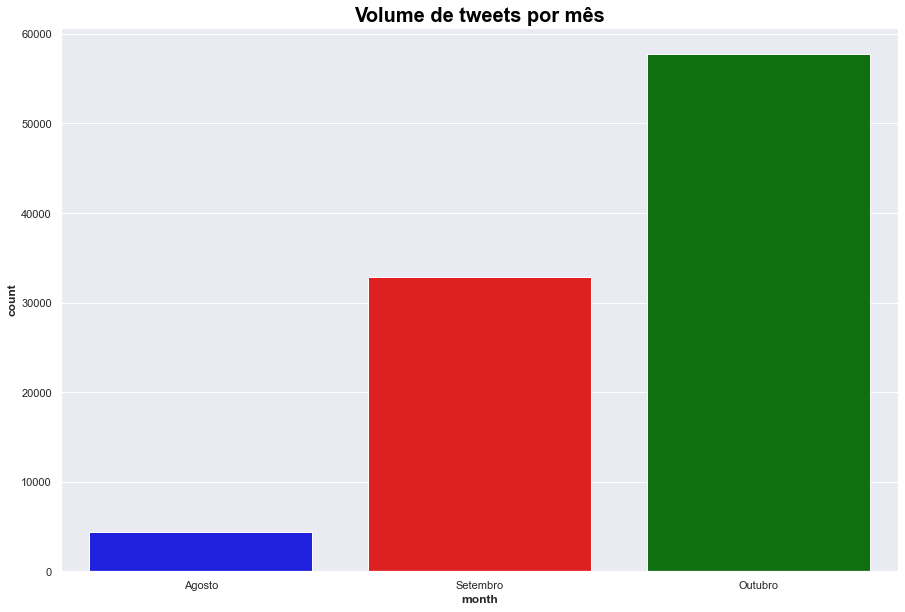

In [12]:
#Criando um countplot para cada mês do ano em relação ao volume de tweets
graph = sns.countplot(data=words_dirty_train_clean,x='month',palette=['blue','red','green'])
graph.set_title('Volume de tweets por mês')
graph.set_xticklabels(labels=['Agosto','Setembro','Outubro']);

Novamente surge a curiosidade do que ocorreu em setembro e outubro para o volume de tweets ter aumentado tanto em relação a agosto

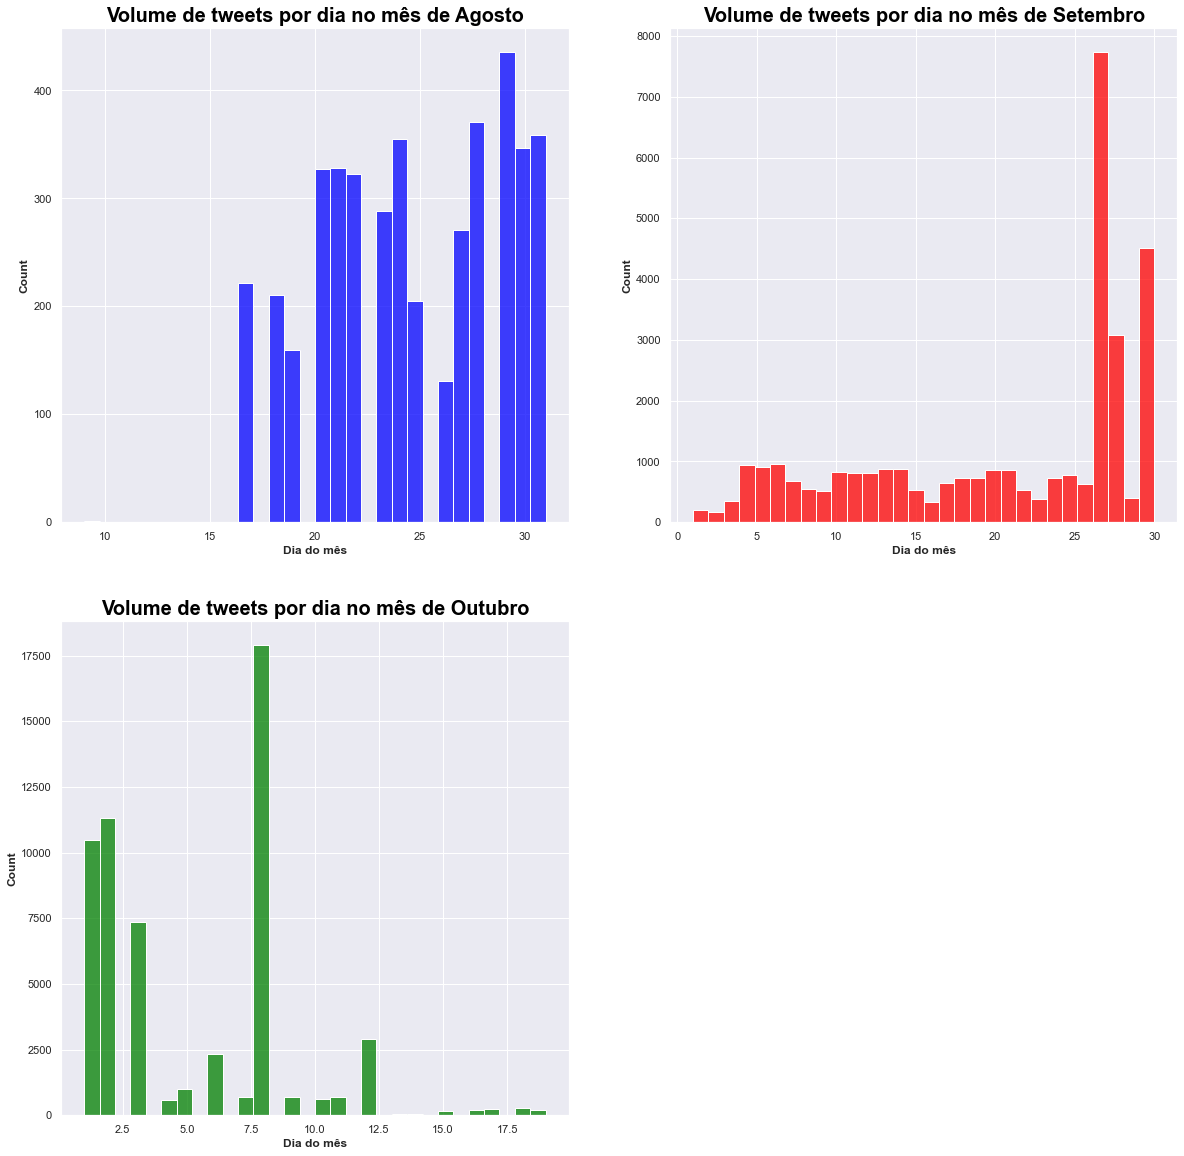

In [13]:
#Criando um grid de subplots
fig, axes = plt.subplots(nrows=2, ncols=2,figsize=(20,20))
axes = axes.ravel()
color = ['blue','red','green']

#Criando um histograma para cada mês do ano
for i, ax,c in zip([8,9,10],axes,color):
    filter = words_dirty_train_clean['month'] == i
    graph = sns.histplot(data=words_dirty_train_clean[filter],x='day',bins=30,ax=ax,color=c)
    if i == 8: 
        i = "Agosto" 
    elif i == 9:  
        i = "Setembro" 
    else: 
        i = "Outubro"
    graph.set_title('Volume de tweets por dia no mês de '+str(i))
    graph.set_xlabel('Dia do mês')

fig.delaxes(axes[3])

Como no dia 27 de setembro, 1,2,8 de outubro houveram picos consideráveis, bem possívelmente foram eventos diferentes sendo intensamente comentados na rede social

Vamos olhar para as querys usadas para buscar as publicações

In [14]:
#Verificando o volume de tweets por query
words_dirty_train_clean['query'].value_counts()

:(               31696
:)               31678
folha             5004
estadao           3880
#fato             3471
g1                3439
exame             3417
#trabalho         3030
#oportunidade     2455
jornaloglobo      2374
veja              2141
#noticia          1114
#novidade          920
#curiosidade       381
Name: query, dtype: int64

Não são muitas querys diferentes e a maior parte está concentrada em emojis. É possível perceber que são querys bem generalistas, vinculadas a grandes empresas de comunicação

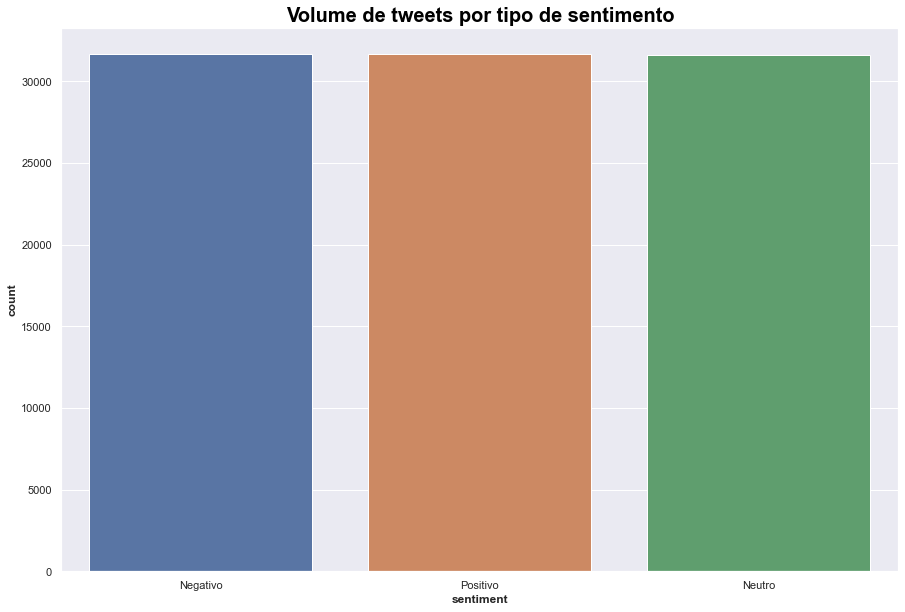

In [15]:
graph = sns.countplot(data=words_dirty_train_clean,x='sentiment')
graph.set_title('Volume de tweets por tipo de sentimento')
graph.set_xticklabels(labels=['Negativo','Positivo','Neutro']);

O dataset está com a variável target bastante balanceada, o que é excelente

In [16]:
#Criando uma tabela dinâmica em que as linhas são a query e as colunas o sentimento
pd.crosstab(index=words_dirty_train_clean['query'],columns=words_dirty_train_clean['sentiment'],values=words_dirty_train_clean['hour'],aggfunc='count')

sentiment            0        1       2
query                                  
#curiosidade       NaN      NaN   381.0
#fato              NaN      NaN  3471.0
#noticia           NaN      NaN  1114.0
#novidade          NaN      NaN   920.0
#oportunidade      NaN      NaN  2455.0
#trabalho          NaN      NaN  3030.0
:(             31696.0      NaN     NaN
:)                 NaN  31678.0     NaN
estadao            NaN      NaN  3880.0
exame              NaN      NaN  3417.0
folha              NaN      NaN  5004.0
g1                 NaN      NaN  3439.0
jornaloglobo       NaN      NaN  2374.0
veja               NaN      NaN  2141.0

Existe consistência nos dados, as querys relacionados a emojis de sentimento negativo resultam em tweets com sentimento negativo e as querys relacionadas a emojis de sentimento positivo resultam em tweets com sentimento positivo. As querys relacionadas a veículos de comunicação resultam em sentimentos neutros

## Pre processamento e continuação da análise exploratória

Para o pre processamento vamos criar uma função para fazer a limpeza dos dados na coluna dos tweets

In [17]:
nlp = spacy.load('pt_core_news_lg')
stopwords_pt = stopwords.words('portuguese')

def pre_process(row,nlp=nlp,stopwords=stopwords_pt):
    #Removendo menções
    row = re.sub(r'@[a-zA-Z0-9_]{1,50}','',row)
    #Removendo o links:
    row = re.sub(r'(https:\/\/.+)','',row)
    #Colocando todas as palavras em minúsculo
    row = row.lower()
    #Removendo todos os :d (sorriso) ou sorriso:p
    row = row.replace(':d','')
    row = row.replace(':p','')
    #Removendo os digitos
    row = re.sub(r'\d+','',row)
    #Removendo a acentuação
    row = unidecode(row)
    #Removendo os caracteres especiais
    row = re.sub(r'[^a-zA-Z0-9]',' ',row)
    #Removendo caracteres repetidos 3 ou mais vezes
    row = re.sub(r'(\w)\1(\1+)',r'\1',row)
    #Removendo os espaços do inicio e final de cada frase
    row = row.strip()
    #Tokenizando
    doc = nlp(row)
    #Removendo as stopwords:
    row = [word for word in doc if word.text not in stopwords_pt]
    #Removendo palavras que não tem lemma
    row = [word.lemma_.strip() for word in row]
    #Removendo elementos vazio 
    row = [word for word in row if word != '']
    return row

In [18]:
#Criando as variáveis do dataset limpo
words_train_clean = words_dirty_train_clean.copy() #Treino
words_sub_clean = words_dirty_sub_clean.copy() #Teste

#Aplicando a função de pre-processamento linha a linha ->output igual uma lista de tokens para cada linha
words_train_clean['text_clean'] = words_train_clean['text'].apply(lambda x: pre_process(x))
#Juntando essa lista de tokens em uma única string
words_train_clean['text_joined'] = words_train_clean['text_clean'].apply(lambda x: ' '.join(x))

#Aplicando a função de pre-processamento linha a linha ->output igual uma lista de tokens para cada linha
words_sub_clean['text_clean'] = words_sub_clean['text'].apply(lambda x: pre_process(x))
#Juntando essa lista de tokens em uma única string
words_sub_clean['text_joined'] = words_sub_clean['text_clean'].apply(lambda x: ' '.join(x))

In [19]:
words_train_clean.head()

text  sentiment  query  \
0  Rio elege maior bancada policial de sua histór...          2  folha   
1  fiquei tão triste quando eu vi o preço da câme...          0     :(   
2  Para Theresa May, seu plano para o Brexit é a ...          2  exame   
3  caralho eu quero proteger a danielly em um pot...          0     :(   
4                         @SiCaetano_ viva o caos :)          1     :)   

         date  month  day  hour  \
0  2018-10-09     10    9    18   
1  2018-09-30      9   30     4   
2  2018-09-17      9   17    17   
3  2018-10-02     10    2     1   
4  2018-10-03     10    3     3   

                                          text_clean  \
0  [rir, eleger, maior, bancada, policial, histor...   
1           [ficar, tao, triste, vir, preco, camera]   
2       [theresa, may, planar, brexit, unica, opcao]   
3  [caralho, querer, proteger, danielly, pote, ta...   
4                                       [vivo, caos]   

                                      text_joined  
0     rir eleger maior bancada policial historiar  
1               ficar tao triste vir preco camera  
2           theresa may planar brexit unica opcao  
3  caralho querer proteger danielly pote tadinhaa  
4                                       vivo caos

Agora que realizamos o nosso pre processamente, vamos olhar como ficou nosso vocabulário de palavras e começar a platar nossas wordsclouds

In [20]:
# Criando uma função para gerar nossos datasets de wordcloud
def wc_df(df, filter=False,filter_type=None,column='text_clean'):
    #Se houver filtro usa ele
    
    if filter:
        #Criando um dataframe com as palavras únicas
        vocabulary = pd.DataFrame(
                                np.concatenate(df.loc[filter_type,column].values),
                                columns=['word']
                                )
    else:
        #Criando um dataframe com as palavras únicas
        vocabulary = pd.DataFrame(
                                np.concatenate(df[column].values),
                                columns=['word']
                                )
    #Criando um dicionário com as palavras únicas                            
    dict_wc = vocabulary.groupby('word').size().to_dict()
    return dict_wc

#Função de plot da word cloud
def plot_cloud(wordcloud):
    # Set figure size
    plt.figure(figsize=(40, 30))
    # Display image
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off")

#Criando nossa lista de stopwords
stopwords_pt = stopwords.words('portuguese')
#Vamos manter as palavras "não" e "muito" já que elas podem ser importantes para a análise
stopwords_pt =[word for word in stopwords_pt if word not in ['não','muito']]

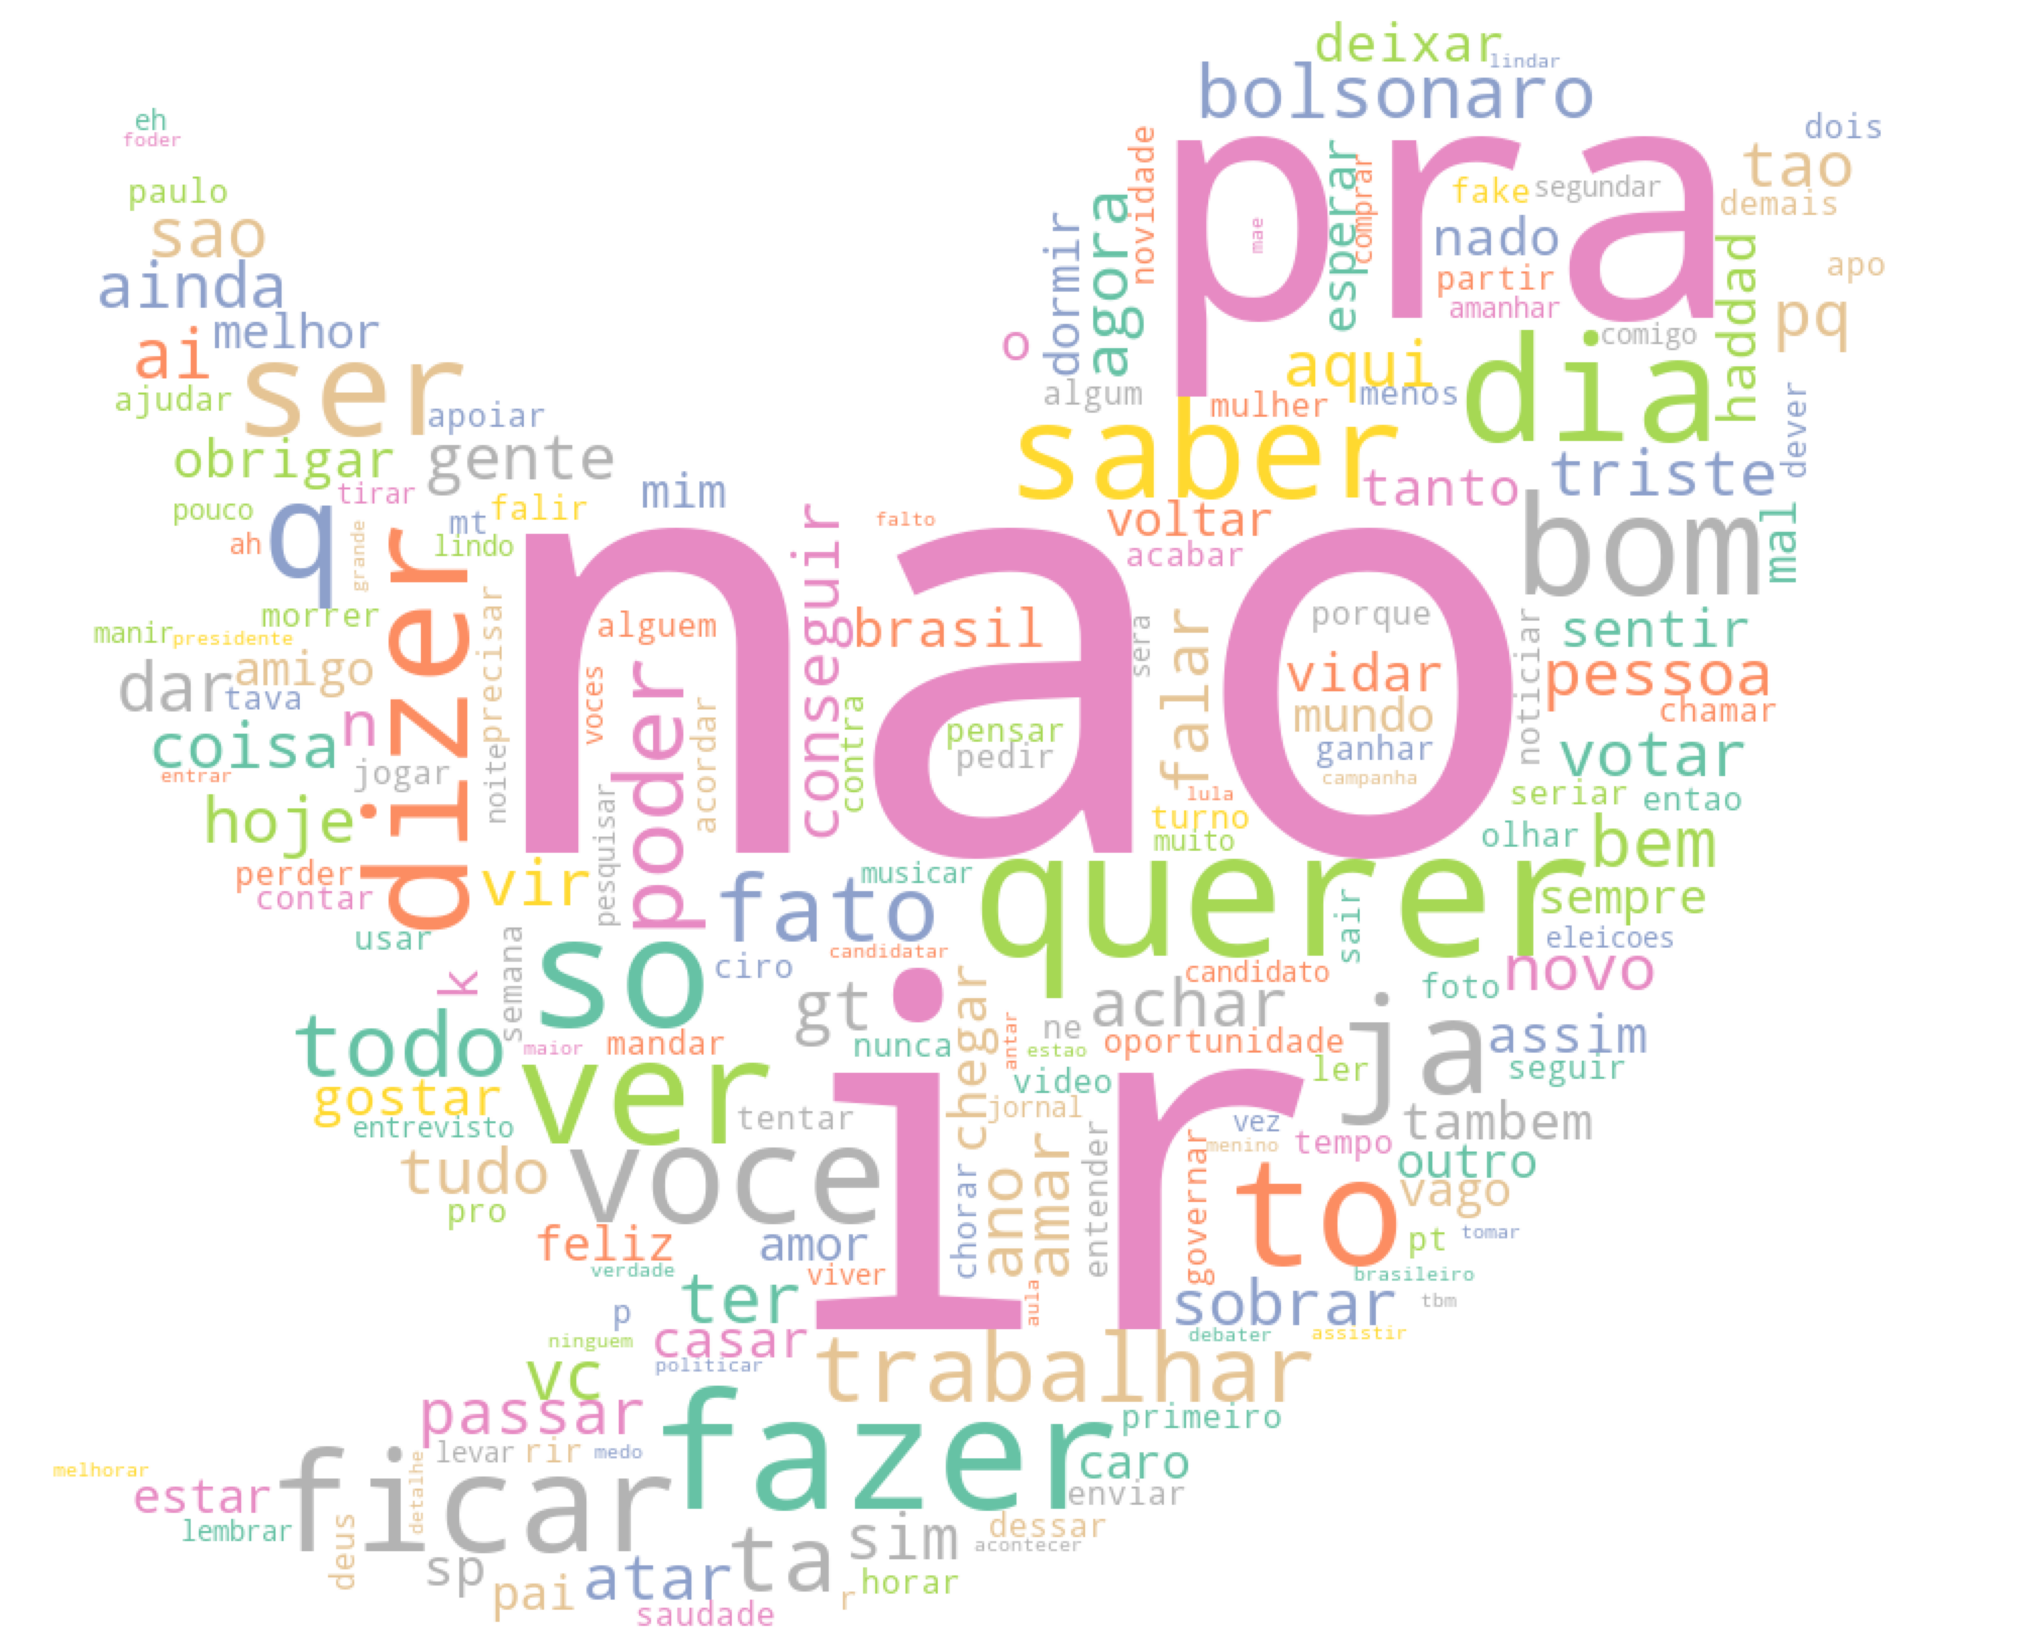

In [21]:
mask = np.array(Image.open('twitter.png'))
wordcloud = (
                WordCloud(
                            width=3000,
                            height=2000,
                            random_state=1,
                            background_color='white',
                            colormap='Set2',
                            collocations=False,
                            stopwords=stopwords_pt,
                            mask = mask
                        ).generate_from_frequencies(wc_df(words_train_clean))
         )       
plot_cloud(wordcloud)

Algumas impressões iniciais pela wordcloud: 
- Algumas abreviações/expressões informais como "q", "n","pq" e algumas letras aletórias "k","r" e "gt" são bem expressivas em aparições.
- Vemos também alguns nomes de políticos como "Ciro", "Bolsonaro","Haddad" e palavras relacionadas como "presidente", "candidatar", "governar", "votar", "eleições", "candidato", "campanha", "turno", "debater"
- Algumas contrações informações que deveriam ficar nas stopwords acabaram passando despercebido e talvez tenhamos que removelas como:
    - "pra" (para), 
    - "to" (estou), 
    - "tao" e "estao" (estão),
    - "mt" que provavelmente é de "muito",
    - "eh" (é), 
    - "o" por algum motivo não foi removida,
    - "tbm" (também), 
    - "pro" (para e o),
    - "vc" (você)
    - "ta" (esta)
    - "tava" (estava)
    - "nao" (não)
- Alguns verbos aparecendo bastante "ir", "querer", "trabalhar","dizer","saber"

### Sentimentos positivos

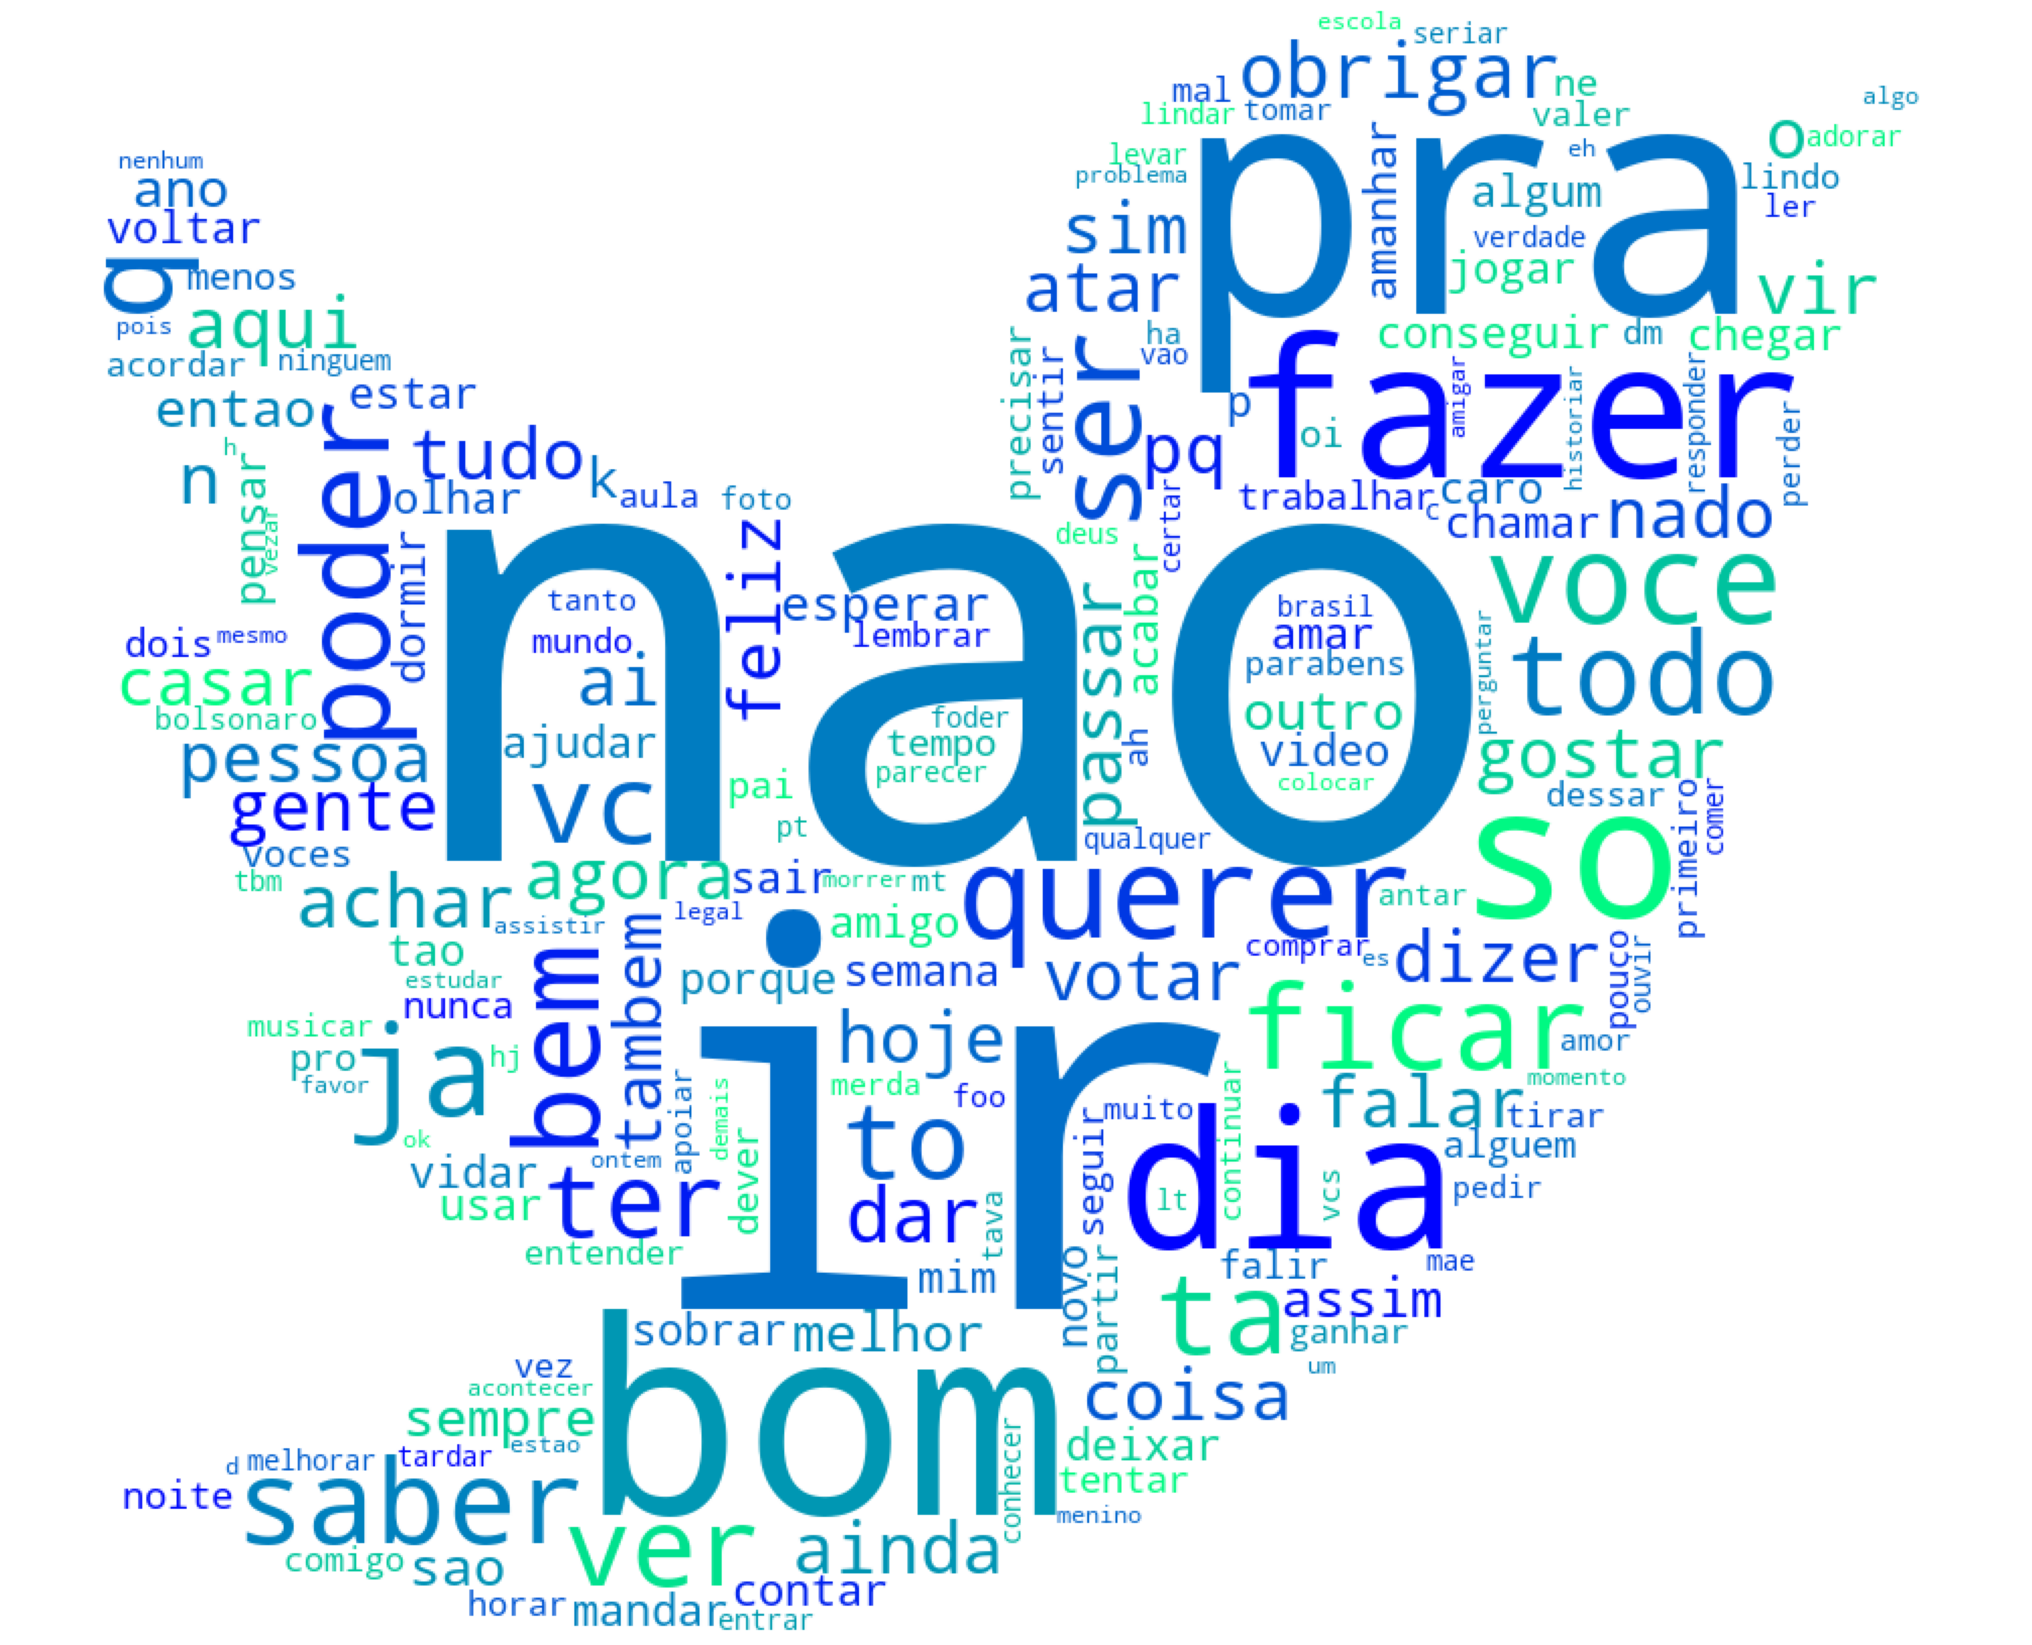

In [22]:
mask = np.array(Image.open('twitter.png'))
#Gerando um filtro para pegar opiniões positivas
filter = (words_train_clean['sentiment'] == 1)
wordcloud = (
                WordCloud(
                            width=3000,
                            height=2000,
                            random_state=1,
                            background_color='white',
                            colormap='winter',
                            collocations=False,
                            stopwords=stopwords_pt,
                            mask = mask
                        ).generate_from_frequencies(wc_df(words_train_clean,filter=True,filter_type=filter))
         )       
plot_cloud(wordcloud)

É possível perceber que várias palavras que apareceram frequentemente remetem a sentimentos positivos como: "bom", "feliz","gostar", "poder", "melhor", "amigo","dia","casar","lindo","verdade","amar","adorar", "bem"

Entretando algumas palavras frequentes podem passar uma conotação negativa, quando lidas fora de contexto, por exemplo: "falir","problema","merda","caro","obrigar","mal"

É interessante perceber que a palavra "bolsonaro" aparece de forma expressiva nos sentimentos negativos, indicando que talvez exista um vies político nessa amostra

### Sentimentos negativos

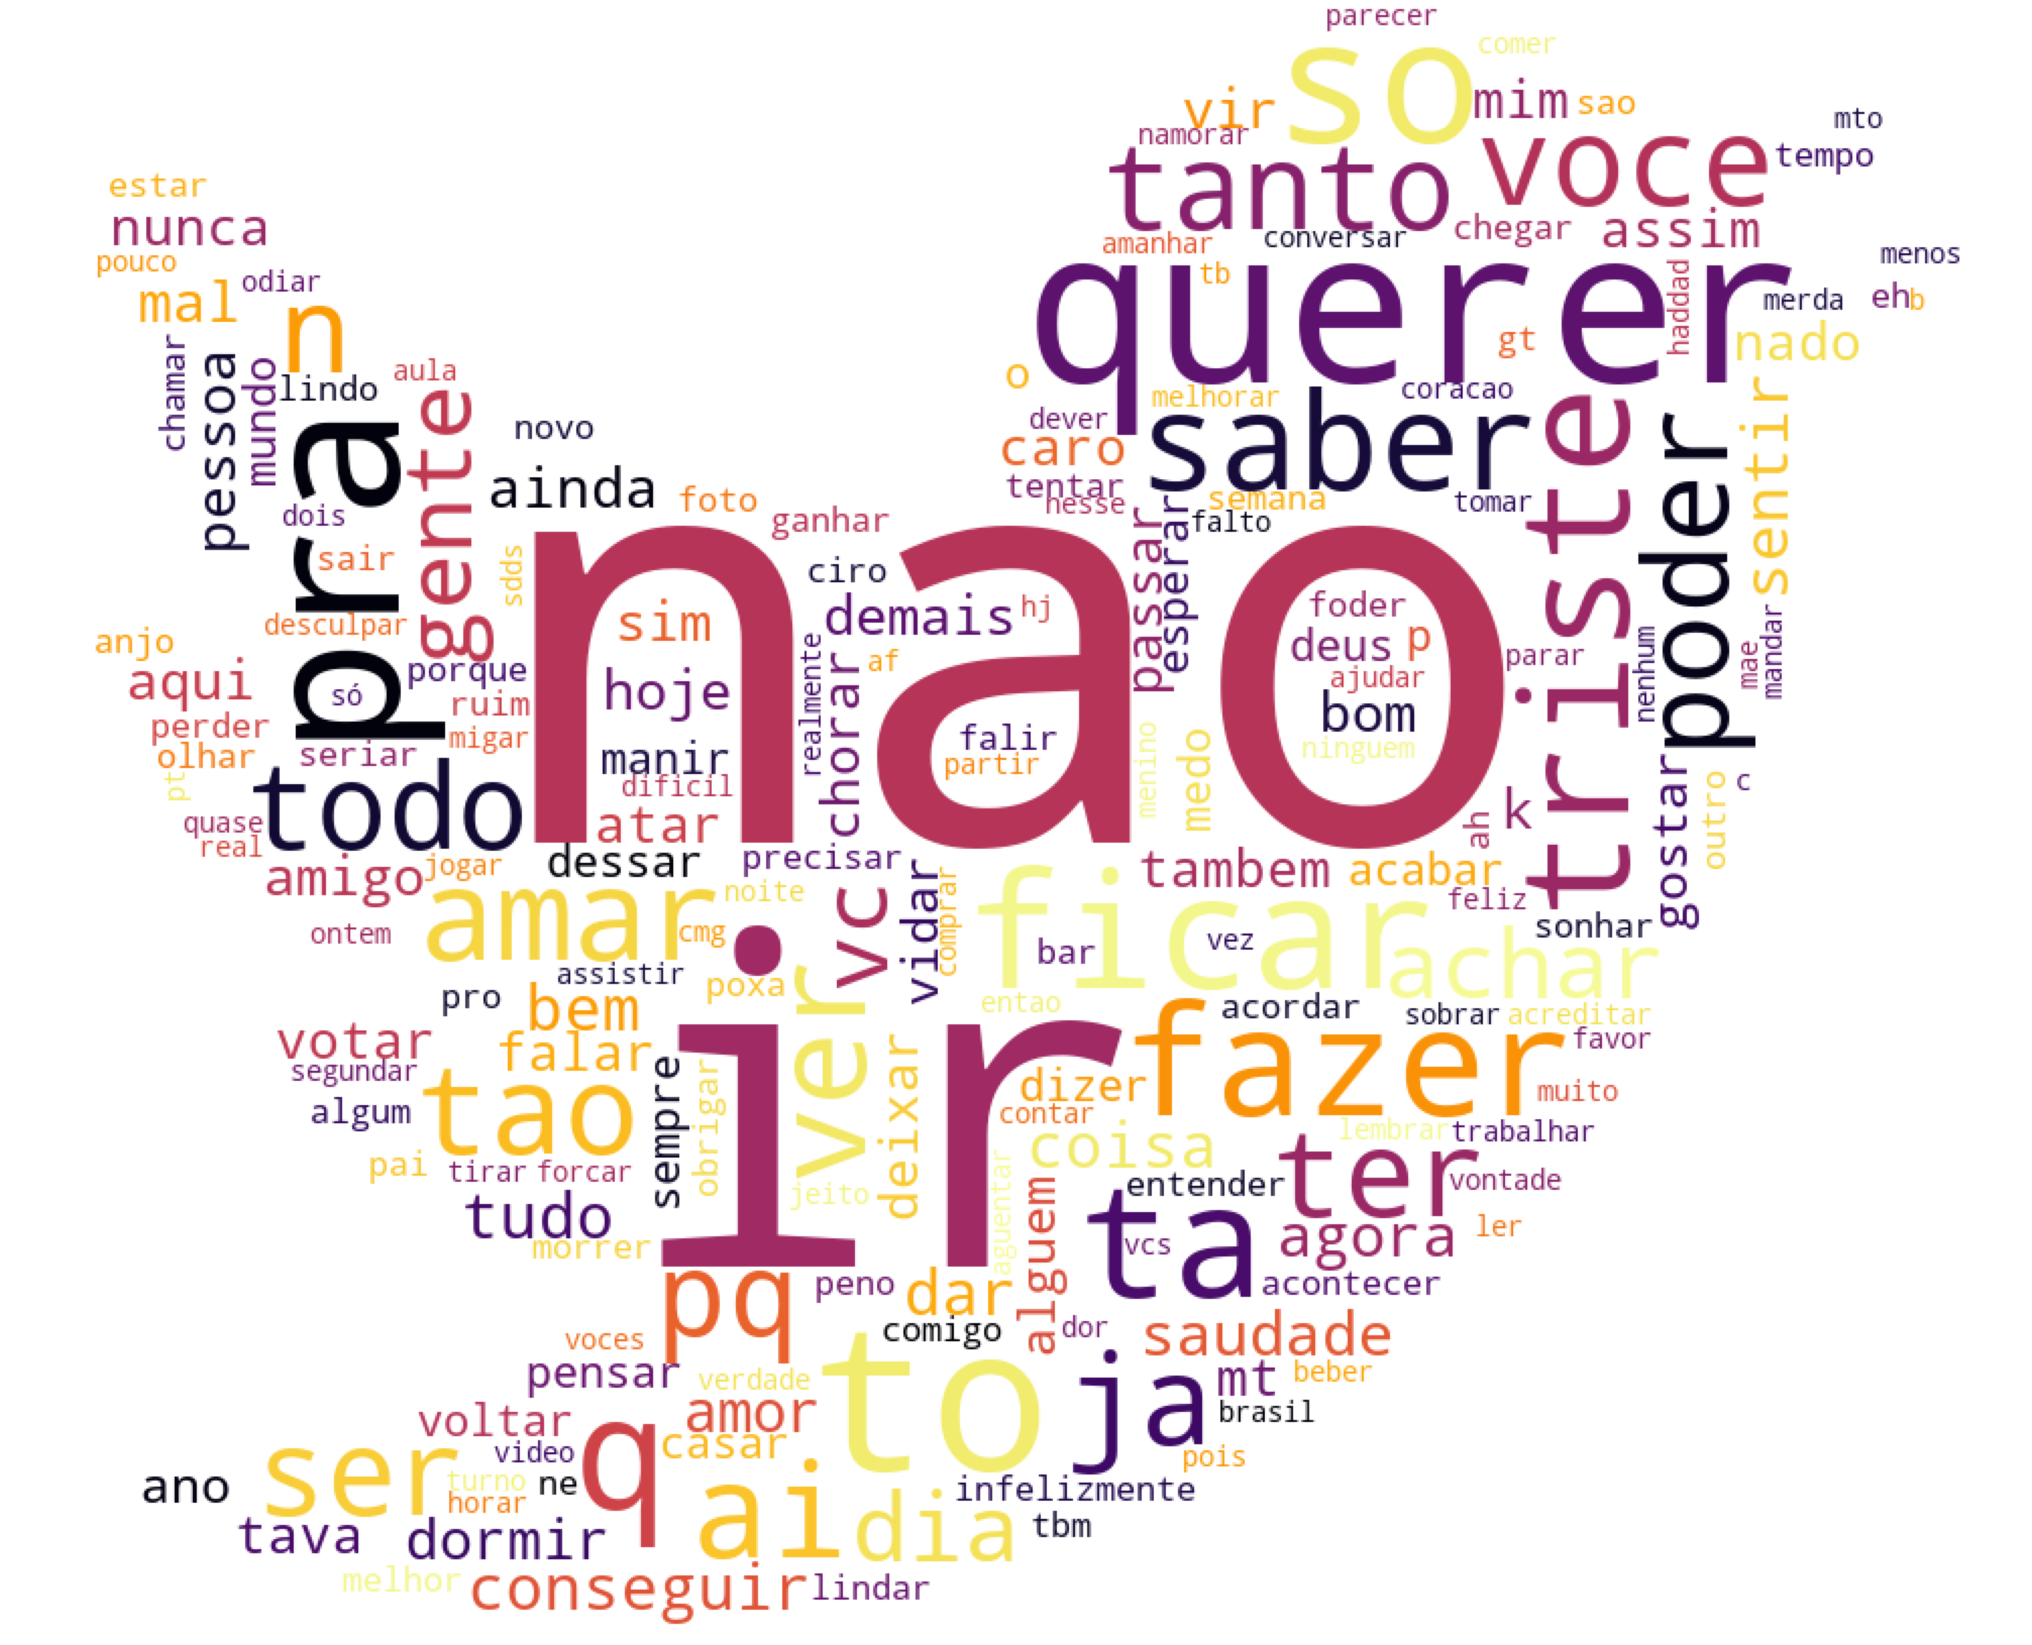

In [23]:
mask = np.array(Image.open('twitter.png'))
#Gerando um filtro para pegar opiniões negativas
filter = (words_train_clean['sentiment'] == 0)
wordcloud = (
                WordCloud(
                            width=3000,
                            height=2000,
                            random_state=1,
                            background_color='white',
                            colormap='inferno',
                            collocations=False,
                            stopwords=stopwords_pt,
                            mask = mask
                        ).generate_from_frequencies(wc_df(words_train_clean,filter=True,filter_type=filter))
         )       
plot_cloud(wordcloud)

Algumas palavras com forte conotação de sentimento negativo que chama a atenção "triste", "mal","chorar","saudade","infelizmente", "caro","morrer"

Aqui os políticos "haddad" e "ciro" aparecem mais fortemente, podendo indicar que essa amostra de tweets tem mais vies de posicionamento político favorável a direita

Por fim, vamos repetir o processo para as amostras neutras

### Sentimentos neutros

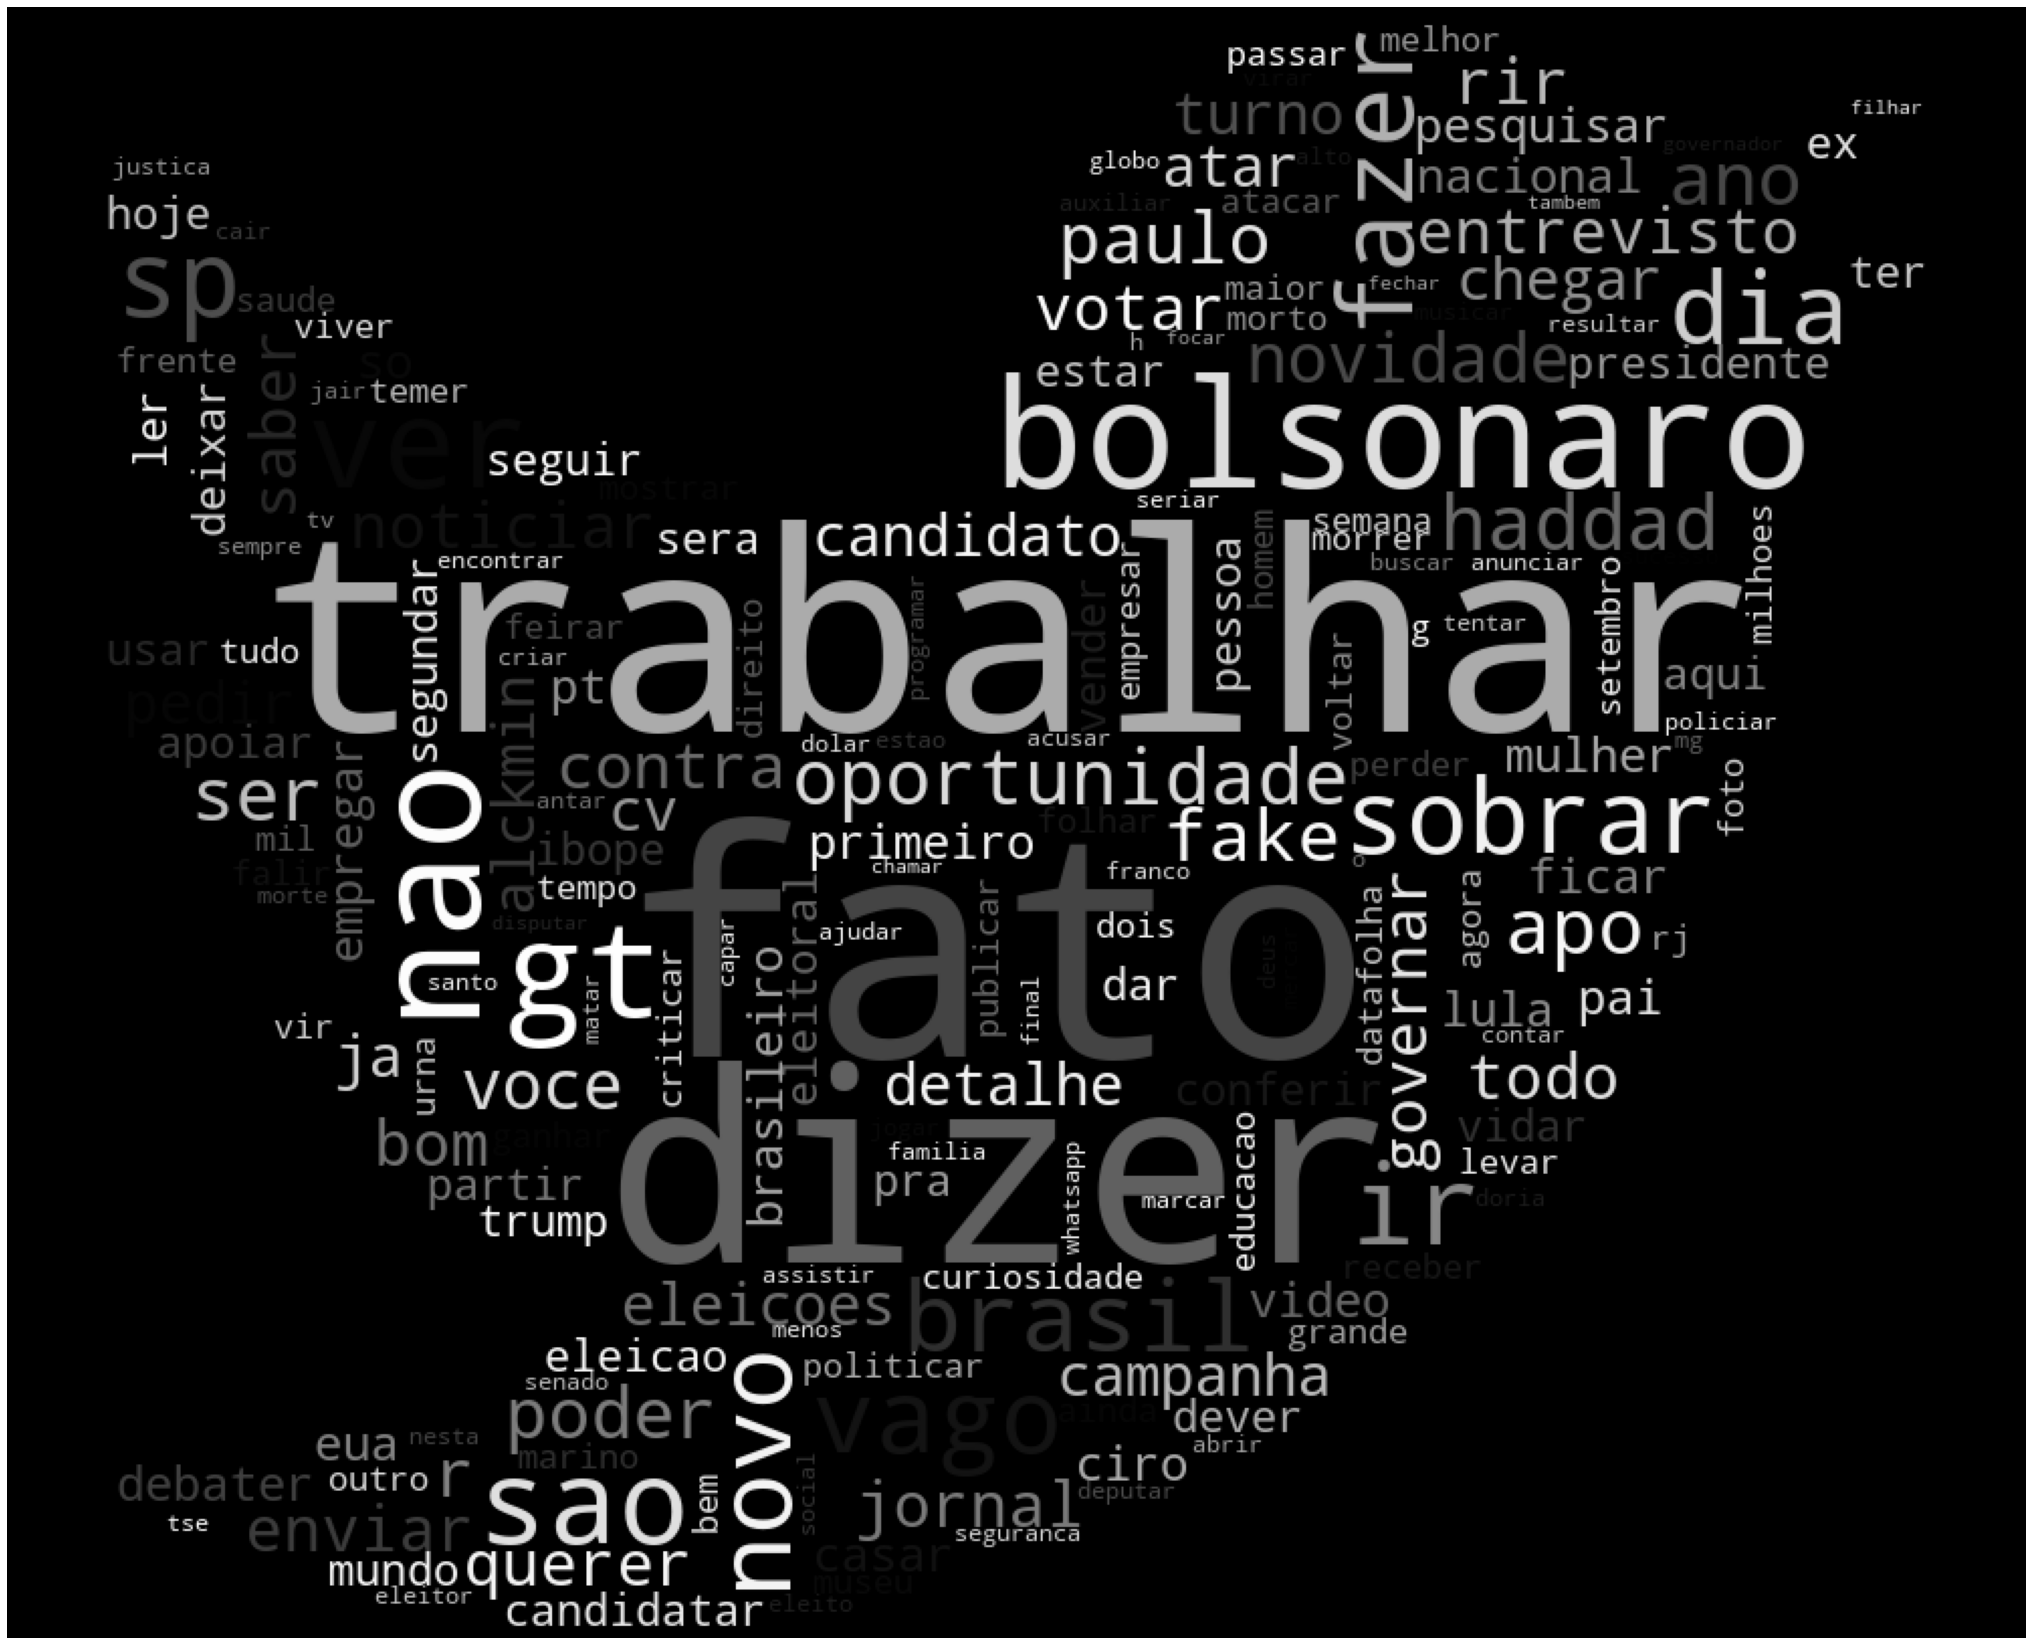

In [24]:
mask = np.array(Image.open('twitter.png'))
#Gerando um filtro para pegar opiniões neutras
filter = (words_train_clean['sentiment'] == 2)
wordcloud = (
                WordCloud(
                            width=3000,
                            height=2000,
                            random_state=1,
                            background_color='black',
                            colormap='Greys',
                            collocations=False,
                            stopwords=stopwords_pt,
                            mask = mask
                        ).generate_from_frequencies(wc_df(words_train_clean,filter=True,filter_type=filter))
         )       
plot_cloud(wordcloud)

Aqui as palavras mais expressivas mudam consideravelmente e percebemos que os políticos Bolsonaro, Haddad e Ciro são bastante citados, indo contra nossa hipótese que a amostra poderia ter um vies de posicionamento político favorável a direita. Além disso vemos a presença forte do político Lula e do Geraldo Alckmin nos tweets de sentimento neutro.

O tema política aqui é bem presente por meio de palavras como "candidatar","campanha","eleições","senado","trump","deputar","governar","candidato",'votar',"pesquisa","urna","ibope"

Vemos várias palavras relacionadas a conseguir emprego como "trabalhar","empregar","entrevista", "oportunidade"

### Análise sobre os dias 27 de setembro e 1,2,8 de outubro

Tendo em vista que entre 27 de setembro e o início de outubro tivemos um volume muito maior de tweets tinhamos uma hipótese de que algum evento poderia ter ocorrido. Analisando as words clouds acima e tendo em vista que isso foi muito próximo ao primeiro turno das eleições de 2018 temos um possível motivo tanto para o volume ter aumentando próximo de setembro (se aproximando do dia da votação), quando para no dia 8 termos um volume expressivo de tweets (o dia da votação)

Considerando que no primeiro turno o político Bolsonaro teve um elevado volume de votos e tinha um discurso político bastante forte em torno de gerar mais empregos, faz sentido ele ser bastante comentado e também faz sentido a expressividade de palavras relacionadas a trabalho

### Análise sobre os horários mais comentados

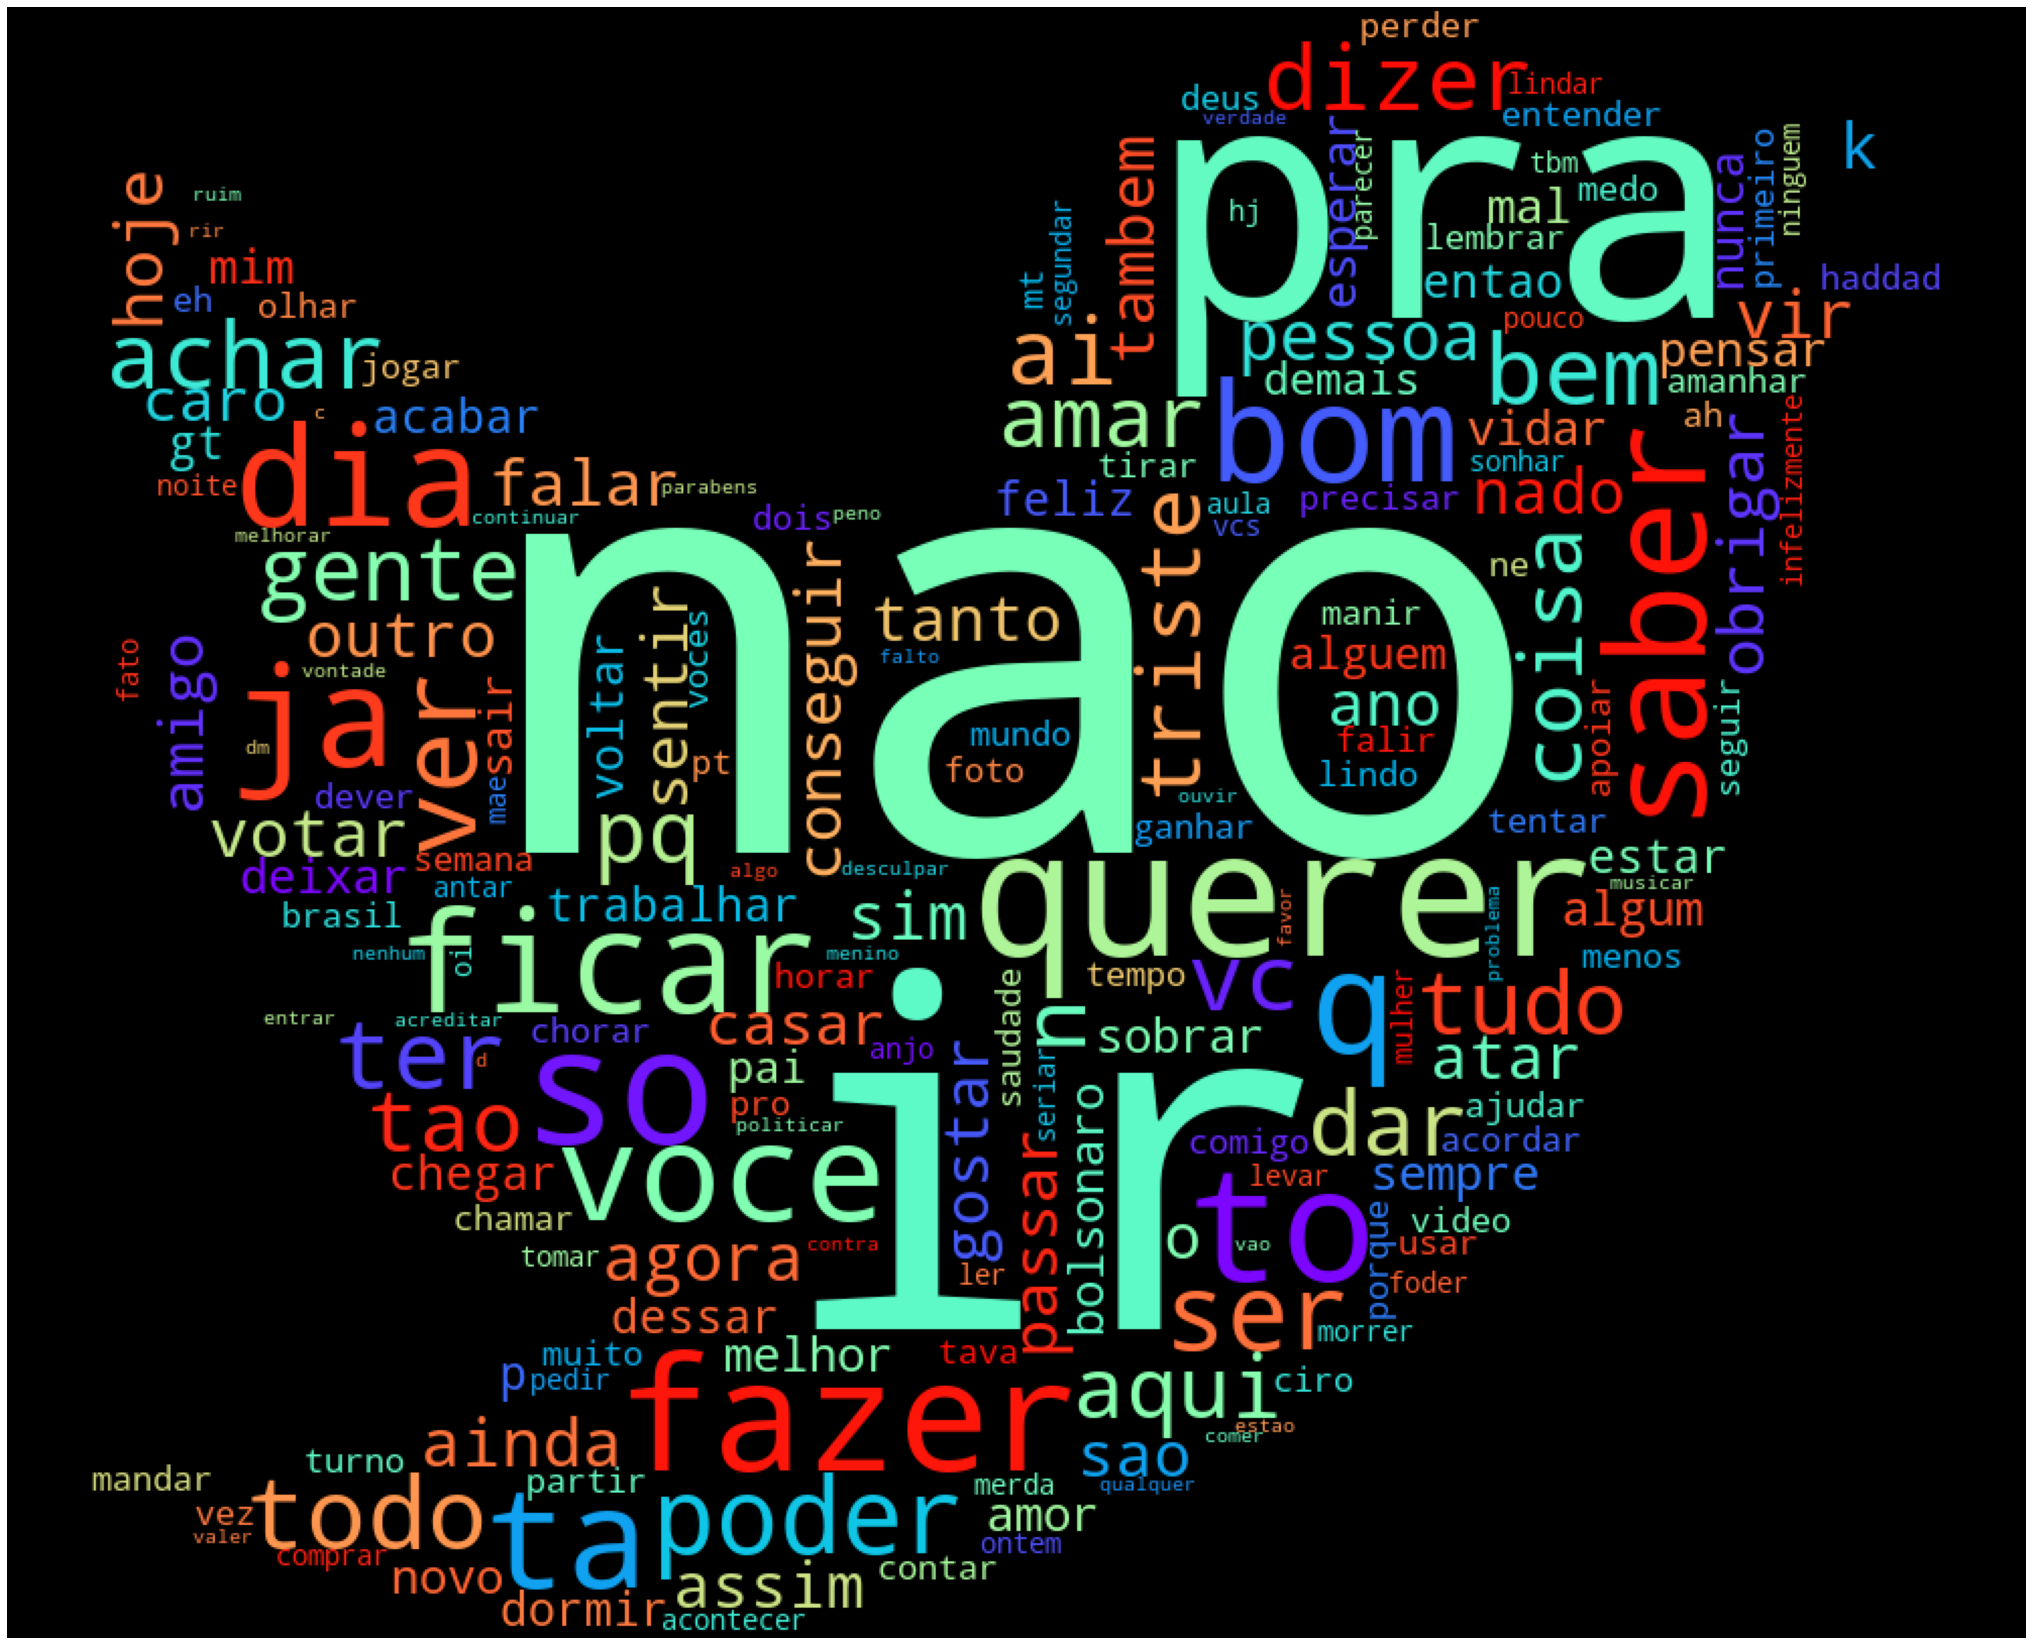

In [25]:
mask = np.array(Image.open('twitter.png'))
#Gerando um filtro para pegar nos meses de setembro e outubro entre as janelas de horário de maior intensidade (2h - 4h e 11h - 23h)
filter = ((words_train_clean['month'].isin([10,9])) & 
        (words_train_clean['hour'].isin([2,3,4,11,12,13,14,15,16,17,18,19,20,21,22,23])) 
        & (words_train_clean['day'].isin([1,2,3,8,27])))
wordcloud = (
                WordCloud(
                            width=3000,
                            height=2000,
                            random_state=1,
                            background_color='black',
                            colormap='rainbow',
                            collocations=False,
                            stopwords=stopwords_pt,
                            mask = mask
                        ).generate_from_frequencies(wc_df(words_train_clean,filter=True,filter_type=filter))
         )       
plot_cloud(wordcloud)

(Escrever alguma conclusão aqui)

# Passo 3: Modelagem e conclusões

Inicaremos o processo de modelagem e como baseline usaremos a transformação de bag of words usando. Testaremos uma série de modelos e analisaremos as principais métricas (acurrácia, recall, precision, auc)

In [26]:
#Colocar o train_test_splot
def baseline_transform(models,X=words_train_clean['text_joined'],y=words_train_clean['sentiment'],verbose=False):
    models_dict = {}
    metrics = ['recall_weighted','precision_weighted','f1_weighted','accuracy','roc_auc_ovr']
    
    if verbose:
        print("Iniciando o loop de modelos")

    for model in models:
        if verbose:
            print(f"Fit do modelo {model} iniciado")
        
        pipe = Pipeline(steps=[('vect',CountVectorizer()),
                                (model,models[model])])
        
        scores = cross_validate(pipe,X,y,cv=5,scoring=metrics,return_train_score=True,n_jobs=-1)

        # Dicionário com as métricas de cada modelo                    
        models_dict[model] = {'recall_test': scores['test_recall_weighted'].mean(),
                                     'recall_train': scores['train_recall_weighted'].mean(),
                                     'precision_test': scores['test_precision_weighted'].mean(),
                                     'precision_train': scores['train_precision_weighted'].mean(),
                                     'f1_test': scores['test_f1_weighted'].mean(),
                                     'f1_train': scores['train_f1_weighted'].mean(),
                                     'accuracy_test': scores['test_accuracy'].mean(),
                                     'accuracy_train': scores['train_accuracy'].mean(),
                                     'roc_auc_test': scores['test_roc_auc_ovr'].mean(),
                                     'roc_auc_train': scores['train_roc_auc_ovr'].mean(),
                                    }
        if verbose:
            print(f"Fit do modelo {model} finalizado")                    
    tabela = pd.DataFrame(models_dict)
    return tabela

In [ ]:
models = {  'Random Forest': RandomForestClassifier(random_state=43,n_jobs=-1),
            'Gradiente Boost': GradientBoostingClassifier(random_state=43),
            'Regressão Logística': LogisticRegression(random_state=43),
            'XGBoost': XGBClassifier(random_state=43,eval_metric='logloss',use_label_encoder=False,n_jobs=-1),
            'Catboost': CatBoostClassifier(random_state=43,verbose=False)
         }

baseline_table = baseline_transform(models)

In [31]:
baseline_table

Random Forest  Gradiente Boost  Regressão Logística  \
recall_test           0.755947         0.675442             0.792232   
recall_train          0.988316         0.680721             0.881700   
precision_test        0.762187         0.710078             0.792903   
precision_train       0.988350         0.715113             0.881664   
f1_test               0.757200         0.681613             0.792320   
f1_train              0.988326         0.686803             0.881614   
accuracy_test         0.755947         0.675442             0.792232   
accuracy_train        0.988316         0.680721             0.881700   
roc_auc_test          0.902055         0.855094             0.921686   
roc_auc_train         0.998497         0.859914             0.968030   

                  XGBoost  Catboost  
recall_test      0.742463  0.765768  
recall_train     0.768284  0.779668  
precision_test   0.752804  0.769975  
precision_train  0.778742  0.783336  
f1_test          0.744609  0.766339  
f1_train         0.770250  0.779950  
accuracy_test    0.742463  0.765768  
accuracy_train   0.768284  0.779668  
roc_auc_test     0.896061  0.907907  
roc_auc_train    0.915089  0.917341

Considerando que noss objetivo é classificar o tweet corretamente, focaremos na métrica de precision. O motivo da escolha dessa métrica é o seguinte: provavelmente serão analisados amostras de tweets, dessa forma, nosso objetivo é acertar o maior número de sentimentos corretos naquela amostra e não acertar o maior numero de tweets classificados corretos (recall)

Considerando que o modelo de regressão logística foi o melhor para essa métrica usaremos ele como nosso modelo baseline para testar diferentes transformações de dados. Testaremos as seguintes técnicas:
- Bag of words
- TF-IDF
- Word2Vec
- Doc2Vec

In [48]:
def train_test_word2vec(x,type,model):
    '''Função para criar as amostras de teste e treino do word2vec'''
    X_w2v_sn = [] #lista para somar os vetores
    for phrase in x:
        vecs = []
        for word in phrase:
            if word in model.wv.index_to_key:
                vecs.append(model.wv.get_vector(word))
        if vecs:
            soma_normalizada = np.sum(vecs, axis=0) / np.linalg.norm(np.sum(vecs, axis=0))
            X_w2v_sn.append(soma_normalizada)
        else:
            X_w2v_sn.append(np.zeros(model.vector_size))
    return np.array(X_w2v_sn)


X = words_train_clean['text_joined'].copy()
y = words_train_clean['sentiment'].copy()
#Treino para o bag of words e para o TF-IDF (passamos de treino e teste uma sentença)
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                     y, 
                                                     test_size = 0.3, 
                                                     random_state = 42)

X_ = words_train_clean['text_clean'].copy()
y_ = words_train_clean['sentiment'].copy()
#Treino para doc2vec
X_train_, X_test_, y_train_, y_test_ = train_test_split(X_, 
                                                     y_, 
                                                     test_size = 0.3, 
                                                     random_state = 42)

def read_corpus_doc2vec(list_sentences, tokens_only=False):
  '''Função para criar os identificadores únicos para os documentos'''
  if tokens_only:
    return list_sentences
  else:
    lista = []
    for i, line in enumerate(list_sentences):
      lista.append(doc2vec.TaggedDocument(line, [i]))
    return lista

def train_test_doc2vec(x,model):
  '''Função para criar as amostras de teste e treino do word2vecc'''
  X_d2v = []
  for phrase in x:
    X_d2v.append(model.infer_vector(phrase))
  return np.array(X_d2v)

#Criando datasets de treino e teste para cada transformação

#####Bag of words#####
cv = CountVectorizer()
X_train_cv = cv.fit_transform(X_train)
X_test_cv = cv.transform(X_test)
print("Bag of words criado")

######TF-IDF#####
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfid = tfidf.transform(X_test)
print('TF-IDF criado')

######Word2Vec skipgram#####
w2v_s = Word2Vec(sentences=X_train_, vector_size=500, min_count=5, workers=-1,sg=1)
X_train_w2v_sn_skip = train_test_word2vec(X_train_,type=1,model=w2v_s)
X_test_w2v_sn_skip = train_test_word2vec(X_test_,type=1,model=w2v_s)
print('Word2Vec skipgram criado')


#####Word2Vec cbow#####
w2v_c = Word2Vec(sentences=X_train_, vector_size=500, min_count=5, workers=-1,sg=0)
X_train_w2v_sn_cbow = train_test_word2vec(X_train_,type=1,model=w2v_c)
X_test_w2v_sn_cbow = train_test_word2vec(X_test_,type=1,model=w2v_c)
print('Word2Vec cbow criado')

#####Doc2vec#####
train_corpus = read_corpus_doc2vec(X_train_)
test_corpus = read_corpus_doc2vec(X_test_, tokens_only=True)
d2v = doc2vec.Doc2Vec(vector_size=500, min_count=2, epochs=20)
d2v.build_vocab(train_corpus)
d2v.train(train_corpus, total_examples=d2v.corpus_count, epochs=d2v.epochs)
X_train_d2v = train_test_doc2vec(X_train_,model=d2v)
X_test_d2v = train_test_doc2vec(X_test_,model=d2v)
print('Doc2vec criado')

Bag of words criado
TF-IDF criado
Word2Vec skipgram criado
Word2Vec cbow criado
Doc2vec criado


In [136]:
def try_transformers(transformers_dict):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    transformers_metrics = {}
    metrics = ['recall_weighted','precision_weighted','f1_weighted','accuracy','roc_auc_ovr']

    for transformer,train_test_sets in transformers_dict.items():
        print(transformer.upper())
        print(f'Treinando {transformer}')
        rl = LogisticRegression(random_state=43,multi_class='ovr',n_jobs=-1)
        
        scores = cross_validate(rl,train_test_sets['X_train'],train_test_sets['y_train'],cv=5,scoring=metrics,n_jobs=-1)
        print(f'Treinamento com {transformer} finalizado')


        print(f'Testando {transformer}')
        rl.fit(train_test_sets['X_train'], train_test_sets['y_train'])
        y_pred_test = rl.predict(train_test_sets['X_test'])
        y_pred_test_prob = rl.predict_proba(train_test_sets['X_test'])
        accuracy_test = accuracy_score(train_test_sets['y_test'], y_pred_test)
        precision_test = precision_score(train_test_sets['y_test'], y_pred_test, average='weighted')
        recall_test = recall_score(train_test_sets['y_test'], y_pred_test, average='weighted')
        f1_test = f1_score(train_test_sets['y_test'], y_pred_test, average='weighted')
        auc_test = roc_auc_score(train_test_sets['y_test'], y_pred_test_prob,multi_class='ovr')
                
        # Dicionário com as métricas de cada modelo                    
        transformers_metrics[transformer] = {'recall_test': recall_test,
                                     'recall_train': scores['test_recall_weighted'].mean(),
                                     'precision_test': precision_test,
                                     'precision_train': scores['test_precision_weighted'].mean(),
                                     'f1_test': f1_test,
                                     'f1_train': scores['test_f1_weighted'].mean(),
                                     'accuracy_test': accuracy_test,
                                     'accuracy_train': scores['test_accuracy'].mean(),
                                     'roc_auc_test': auc_test,
                                     'roc_auc_train': scores['test_roc_auc_ovr'].mean(),
                                    }
        print(f'Teste com {transformer} finalizado')

        print('''        
                 ###############################################
                 ################ Classification Report ###############
                 ###############################################
               ''' )   
        print(classification_report(train_test_sets['y_test'],y_pred_test))
    
        print(50*"*",'\n')
        
    table = pd.DataFrame(transformers_metrics)
    return table

transformers_train_test_sets = {'bag of words':{'X_train':X_train_cv,
                                                'X_test':X_test_cv,
                                                'y_train':y_train,
                                                'y_test':y_test},

                                        'TF-IDF':{'X_train':X_train_tfidf,
                                                'X_test':X_test_tfid,
                                                'y_train':y_train,
                                                'y_test':y_test},

                            'Word2Vec skipgram':{'X_train':X_train_w2v_sn_skip,
                                                'X_test':X_test_w2v_sn_skip,
                                                'y_train':y_train_,
                                                'y_test':y_test_},

                                'Word2Vec cbow':{'X_train':X_train_w2v_sn_cbow,
                                                'X_test':X_test_w2v_sn_cbow,
                                                'y_train':y_train_,
                                                'y_test':y_test_},
                                                
                                    'Doc2vec':{'X_train':X_train_d2v,
                                                'X_test':X_test_d2v,
                                                'y_train':y_train_,'y_test':y_test_}}

In [137]:
table = try_transformers(transformers_train_test_sets)

BAG OF WORDS
Treinando bag of words
Treinamento com bag of words finalizado
Testando bag of words
Teste com bag of words finalizado
        
                 ###############################################
                 ################ Classification Report ###############
                 ###############################################
               
              precision    recall  f1-score   support

           0       0.72      0.75      0.74      9559
           1       0.71      0.69      0.70      9555
           2       0.94      0.94      0.94      9386

    accuracy                           0.79     28500
   macro avg       0.79      0.79      0.79     28500
weighted avg       0.79      0.79      0.79     28500

************************************************** 

TF-IDF
Treinando TF-IDF
Treinamento com TF-IDF finalizado
Testando TF-IDF
Teste com TF-IDF finalizado
        
                 ###############################################
                 ##############

In [107]:
table

bag of words    TF-IDF  Word2Vec skipgram  Word2Vec cbow  \
recall_test          0.789825  0.790175           0.672912       0.672912   
recall_train         0.790887  0.792752           0.671805       0.671805   
precision_test       0.789654  0.787899           0.668426       0.668426   
precision_train      0.790722  0.790073           0.667315       0.667315   
f1_test              0.789600  0.788761           0.669350       0.669350   
f1_train             0.790536  0.791054           0.668367       0.668367   
accuracy_test        0.789825  0.790175           0.672912       0.672912   
accuracy_train       0.790887  0.792752           0.671805       0.671805   
roc_auc_test         0.919020  0.920241           0.846888       0.846888   
roc_auc_train        0.920444  0.921650           0.847571       0.847571   

                  Doc2vec  
recall_test      0.626526  
recall_train     0.618075  
precision_test   0.623894  
precision_train  0.615715  
f1_test          0.624516  
f1_train         0.615702  
accuracy_test    0.626526  
accuracy_train   0.618075  
roc_auc_test     0.807828  
roc_auc_train    0.800081

Fazer:
- Continuar análise exploratória
- Testar tirar as stopwords e fazer o processamento de novo
